In [1]:
import matplotlib.pyplot as plt
import re
import seaborn as sns
import numpy as np
import pandas as pd
import plotly.express as px

import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.linear_model import RANSACRegressor, LinearRegression
from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist
from sklearn.cluster import AgglomerativeClustering, SpectralClustering, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler, RobustScaler

from scipy.linalg import eigh
from scipy.stats import zscore
sns.set()

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Project overview

We cluster solvents and sorbates to make sense of how solvent properties relate to graphene oxide sorption. The goal is practical: find groups of substances that behave similarly so we can link simple measured properties to observed adsorption patterns and guide further experiments and spectra analysis.

Why several clustering methods? Real experimental data are messy and each algorithm reveals a different facet. K-Means gives a quick, easy partition for balanced, spherical groups. Hierarchical clustering shows nested relationships and helps pick natural cut levels. DBSCAN finds dense, irregular groups and isolates noise. Spectral clustering can detect complex shapes but is sensitive to the similarity scale. Running several methods helps check which groupings are stable and which are artefacts of the algorithm.

What we deliver
- concise tables with cluster assignments for each method, so you can compare results side by side;  
- linear correlation observation to confirm the hypothesis of chemical nature of solvent interactions with graphene oxide;
- Plotly dashboards to inspect individual points and test hypotheses;  

Short rationale for choices
- We prioritize interpretability and physical plausibility over raw numeric scores. If a method gives clusters that match known chemistry, we trust it more.  
- We use multiple metrics to support the final choice, but human judgement and domain knowledge are decisive.  
- Because the data are noisy, we expect imperfect clusters. The goal is to extract robust, actionable patterns rather than perfect partitioning.



## 1. Data Loading & Analysis
##### Clustering was based on features such as the permittivity and sorption of the solvents listed below on graphene oxides. In the future, new, purely chemical parameters will be used for multi-feature clustering. The final dataset will be included in the project files.

In [3]:
df = pd.read_excel('Graphene.xlsx', sheet_name='Epsilon')
df.head()

,Name,"Sorption, mmol/g",ε
0,"1,4-Dioxane",5.391513,2.20
1,Acetic anhydride,2.373165,21.00
2,Acetic acid,3.552889,6.20
3,Thionyl chloride,0.644158,9.25
4,Acetylacetone,0.058072,23.10


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Name              43 non-null     object 
 1   Sorption, mmol/g  43 non-null     float64
 2   ε                 43 non-null     float64
dtypes: float64(2), object(1)
memory usage: 1.1+ KB


In [5]:
df['Number of substance'] = df['Name'].factorize()[0]
df.sample(5)

,Name,"Sorption, mmol/g",ε,Number of substance
6,Furfural,1.471976,42.0,6
0,"1,4-Dioxane",5.391513,2.2,0
35,Pyridine-d5,3.752407,12.4,31
21,Water,17.219647,80.1,19
18,"N,N,N',N'-Tetramethylethylenediamine (TEMED)",1.705087,7.4,16


Text(0.5, 1.0, 'Sorption vs Dielectric constant data')

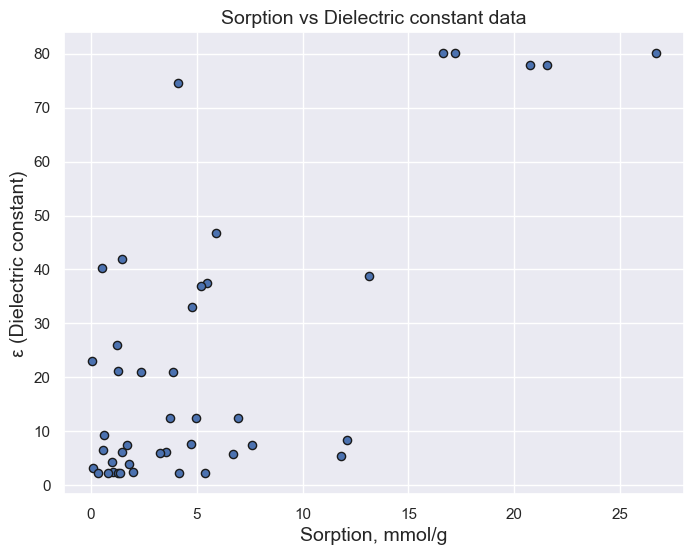

In [6]:
plt.figure(figsize=(8,6))
plt.scatter(df['Sorption, mmol/g'], df['ε'], s = 35, edgecolor = 'k')
plt.xlabel('Sorption, mmol/g', fontsize=14)
plt.ylabel('ε (Dielectric constant)', fontsize=14)
plt.title('Sorption vs Dielectric constant data', fontsize=14)

## 2. Baseline models: K-Means and Agglomerative Hierarchical Clustering

K-Means is a fast, partition-based algorithm that divides the dataset into $K$ clusters by minimizing the within-cluster sum of squared distances; it works well for roughly spherical, similarly sized clusters but can be sensitive to initialization and cluster shape. Agglomerative hierarchical clustering is a bottom-up procedure that successively merges the most similar clusters to produce a tree; it reveals nested structure and does not require specifying $K$ a priori, but results depend on the chosen linkage and distance metric.

To select the number of clusters we used two complementary tools. The **Elbow method** evaluates the within-cluster sum of squares as a function of $K$.

The value of $K$ at which the inertia curve shows a clear “elbow” is taken as a parsimonious choice balancing fit and complexity. The **dendrogram** visualizes cluster merges and merging distances — a large vertical jump in the dendrogram indicates a natural split and suggests an appropriate cut level. Together, the elbow plot provides a quantitative guide for partitioning methods while the dendrogram supplies qualitative insight into hierarchical structure; using them in tandem improves robustness of the cluster-number decision.


### 2.1. Recognizing the optimal number of clusters

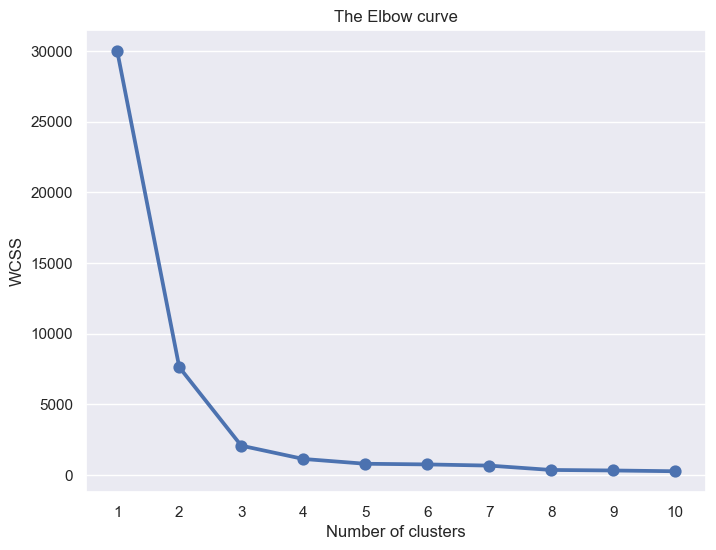

In [7]:
# Elobow Method to find the optimal number of clusters
plt.figure(figsize=(8,6))
X = df.iloc[:, [1, 2]].values
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
sns.pointplot(x= range(1, 11), y = wcss)
plt.title('The Elbow curve')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

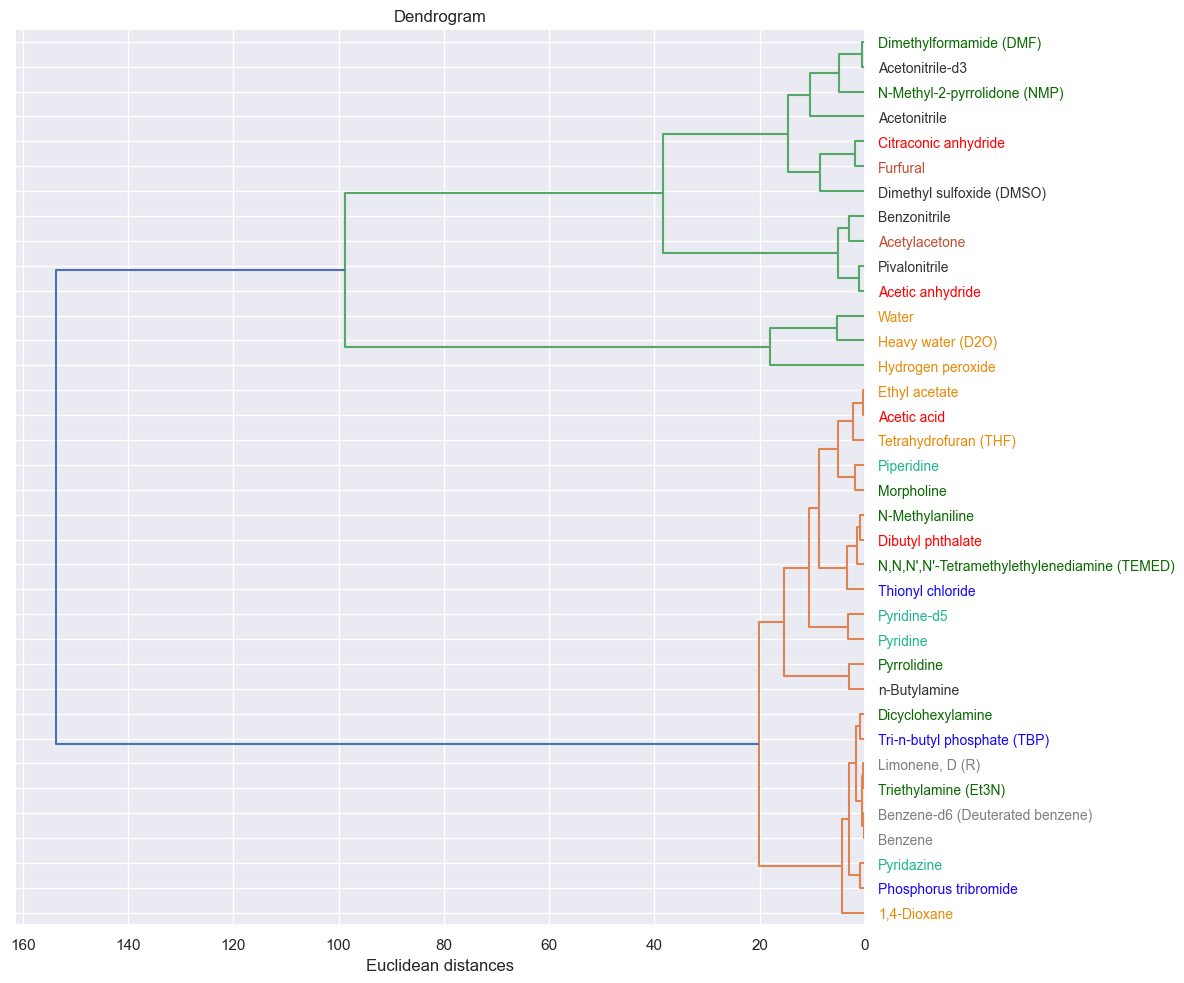

In [8]:
# Dendogram to find the optimal number of clusters using Hierarchical Clustering with distance matrix with dublicate removing
df_removal = df.copy()
df_removal.drop_duplicates(subset=['Name'], keep='last', inplace=True)
distance_matrix = pdist(df_removal[['ε', 'Sorption, mmol/g']].values, metric='euclidean')  
Z = linkage(distance_matrix, method='ward')
# coloring the dendrogram labels matching substance groups
patterns = {
    'carbonyl': r'acetyl|acetone|acetal|furfural',
    'pyridine_piperidine': r'\bpyridine\b|\bpyridazine\b|\bpyridine-d5\b|\bpiperidine\b',
    'oxygenated': r'\bdioxane\b|tetrahydrofuran|1,4-dioxane|dioxane|ethyl acetate|acetate|water|d2o|peroxide',
    'amine': r'\bamine\b|pyrrolidine|dicyclohexylamine|n-?methylaniline|triethylamine|temed|dmf|dimethylformamide|n-methyl-2-pyrrolidone|morpholine',
    'carboxylic_acid': r'\bacid\b|acetic acid|carboxy|anhydride|phthalate',
    'aromatic': r'benzene|furfural|limonene|toluene|benzene-d6',
    'halide_phosphate_other': r'chloride|bromide|phosphorus tribromide|thionyl chloride|phosphate|tbp'
}

def auto_group(name):
    n = name.lower()
    for key, pat in patterns.items():
        if re.search(pat, n):
            return key
    return 'other'

color_for_group = {
    'carbonyl': "#c04f30",
    'pyridine_piperidine': "#1fb48f",
    'oxygenated': "#e78a08",
    'amine': "#0a6901",
    'carboxylic_acid': "#ff0000",
    'aromatic': '#7f7f7f',
    'halide_phosphate_other': "#1707f1",
    'other': '#333333'
}
fig = plt.figure(figsize=(12, 10))
label_colors = [color_for_group[auto_group(name)] for name in df_removal['Name']]

for lbl, color in zip(plt.gca().get_yticklabels(), label_colors):
    lbl.set_color(color)
d = dendrogram(Z, labels=df_removal['Name'].values, orientation='left', leaf_font_size=10)
ax = plt.gca()
for lbl in ax.get_yticklabels():
    text = lbl.get_text()
    lbl.set_color(color_for_group[auto_group(text)])

plt.title('Dendrogram')
plt.xlabel('Euclidean distances')
plt.tight_layout()
plt.show()

### 2.2. K-Means clustering

In [9]:
# K-Means Clustering run
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(X)

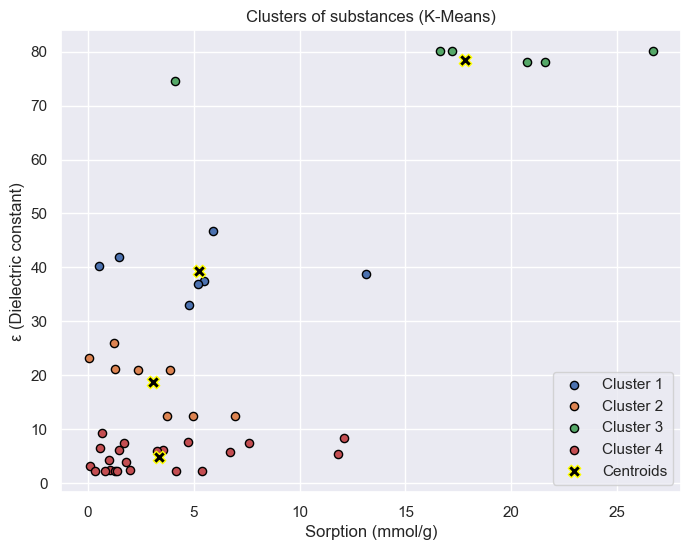

In [10]:
# Plotting the clusters for K-Means
plt.figure(figsize=(8,6))
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s = 35, label = 'Cluster 1', edgecolors='black')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s = 35, label = 'Cluster 2', edgecolors='black')
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s = 35, label = 'Cluster 3',  edgecolors='black')
plt.scatter(X[y_kmeans == 3, 0], X[y_kmeans == 3, 1], s = 35, label = 'Cluster 4', edgecolors='black')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 
            s = 80, label = 'Centroids', c = 'black', edgecolors='yellow', marker='X')
plt.title('Clusters of substances (K-Means)')
plt.xlabel('Sorption (mmol/g)')
plt.ylabel('ε (Dielectric constant)')
plt.legend()
plt.show()

In [11]:
# Clustering Summary
def cluster_df(y):
    clusters = y.astype(int)
    labels = (clusters + 1).astype(str)
    df_t = pd.DataFrame({
        'Name': df['Name'],
        'Cluster': labels,
        'ε (Dielectric constant)': df['ε'].round(2),
        'Sorption (mmol/g)': df['Sorption, mmol/g'].round(3)})
    return df_t

In [12]:
# Cluster DataFrame report for K-Means
df_kmeans = cluster_df(y_kmeans).sort_values('Cluster').reset_index(drop=True)
df_kmeans

,Name,Cluster,ε (Dielectric constant),Sorption (mmol/g)
0,N-Methyl-2-pyrrolidone (NMP),1,33.00,4.791
1,Furfural,1,42.00,1.472
2,Citraconic anhydride,1,40.30,0.544
3,Dimethyl sulfoxide (DMSO),1,46.68,5.919
4,Acetonitrile-d3,1,37.50,5.495
5,Acetonitrile,1,38.80,13.154
6,Dimethylformamide (DMF),1,37.00,5.192
7,Acetonitrile,2,21.01,3.899
8,Pyridine,2,12.40,4.947
9,Pyridine,2,12.40,6.965


### 2.3. Hierarchical clustering

In [13]:
# Hierarchical Clustering run
hc = AgglomerativeClustering(n_clusters = 3, linkage = 'ward')
y_hc = hc.fit_predict(X)

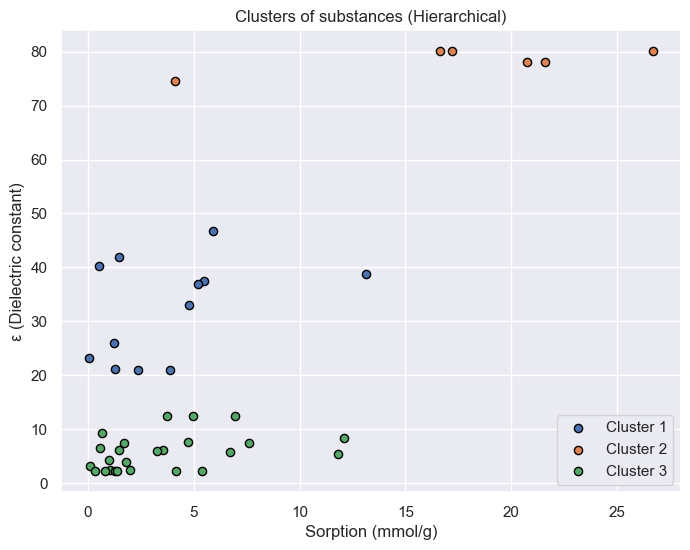

In [14]:
# Plotting the clusters for Hierarchical Clustering
plt.figure(figsize=(8,6))
plt.scatter(X[y_hc == 0, 0], X[y_hc == 0, 1], s = 35, label = 'Cluster 1', edgecolors='black')
plt.scatter(X[y_hc == 1, 0], X[y_hc == 1, 1], s = 35, label = 'Cluster 2', edgecolors='black')
plt.scatter(X[y_hc == 2, 0], X[y_hc == 2, 1], s = 35, label = 'Cluster 3',  edgecolors='black')

plt.title('Clusters of substances (Hierarchical)')
plt.xlabel('Sorption (mmol/g)')
plt.ylabel('ε (Dielectric constant)')
plt.legend()
plt.show()

In [15]:
# Cluster DataFrame report for Hierarchical Clustering
df_hc = cluster_df(y_hc).sort_values('Cluster').reset_index(drop=True)
df_hc

,Name,Cluster,ε (Dielectric constant),Sorption (mmol/g)
0,Acetonitrile-d3,1,37.50,5.495
1,Acetic anhydride,1,21.00,2.373
2,N-Methyl-2-pyrrolidone (NMP),1,33.00,4.791
3,Acetonitrile,1,38.80,13.154
4,Acetylacetone,1,23.10,0.058
5,Furfural,1,42.00,1.472
6,Citraconic anhydride,1,40.30,0.544
7,Pivalonitrile,1,21.10,1.291
8,Benzonitrile,1,25.90,1.218
9,Acetonitrile,1,21.01,3.899


## 3. Spectral Clustering procedure

Spectral clustering represents the dataset as a weighted graph and finds clusters by analysing the spectrum of a graph Laplacian. The main steps used in this work are:
 * Construct an adjacency matrix $A$ from pairwise distances
 * Form the degree matrix $D$ and a Laplacian $L$ or a normalized variant
 * Compute eigenvalues and eigenvectors of $L$
 * Select $K$ using the eigengap heuristic and embed the data into the subspace spanned by the first $K$ eigenvectors
 * Run a standard partitioning algorithm (e.g. K-Means) in that embedding.


### 3.1. Adjacency matrix

We build the adjacency matrix $A\in\mathbb{R}^{n\times n}$ using a Gaussian kernel:

$
A_{ij} = \exp\!\left( -\frac{\lVert x_i - x_j \rVert^2}{2\sigma^2} \right)
$


where $x_i,x_j\in\mathbb{R}^p$ are feature vectors for samples $i$ and $j$, and $\sigma>0$ controls the kernel width (similarity scale). Practical notes:
- $x_i,x_j$ are the vectors of chosen features.
- $\sigma$ sets the distance scale: small $\sigma$ → only very close points get large weight; large $\sigma$ → many weights near 1.
- Common heuristics: choose $\sigma$ as the median of pairwise distances, or tune it by inspecting the adjacency distribution.


In [16]:
# Providing the Adjacency matrix parameters
sigma = 1
A = -1 * np.square(X[:, None] - X[None, :]).sum(axis=-1)
A = np.exp(A / (2* sigma**2))
np.fill_diagonal(A, 0)

### 3.2 Adjacency value distribution plot

The histogram of $A_{ij}$ values helps to diagnose the affinity construction:
- a large spike near zero means the affinity matrix is **sparse**;
- a spread of small but nonzero values suggests intermediate similarities and sensitivity to $\sigma$;
- multimodality or heavy tails indicate heterogeneous local densities (clusters with differing internal scales).

Use this plot to adjust $\sigma$. If almost all values are ≈0 or ≈1, the kernel width should be re-tuned.

Note: we've tried to take the common which is $\sigma$ = 1. In the bottom of the particular notebook you will be able to see the adjustment of the $\sigma$-value


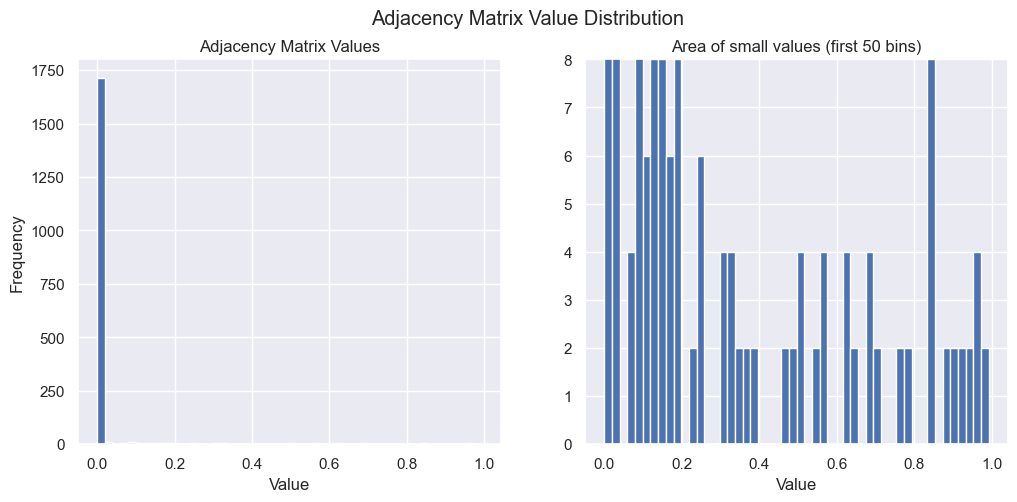

In [17]:
# Adjacency matrix value distribution plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

bin_values, _, _ = ax1.hist(A.flatten(), bins=50)

ax2.hist(A.flatten(), bins=50)
ax2.set_ylim([0, bin_values[9]])
ax1.set_xlabel('Value')
ax2.set_xlabel('Value')
ax1.set_ylabel('Frequency')
ax1.set_title('Adjacency Matrix Values')
ax2.set_title('Area of small values (first 50 bins)')
fig.suptitle('Adjacency Matrix Value Distribution')
plt.show()

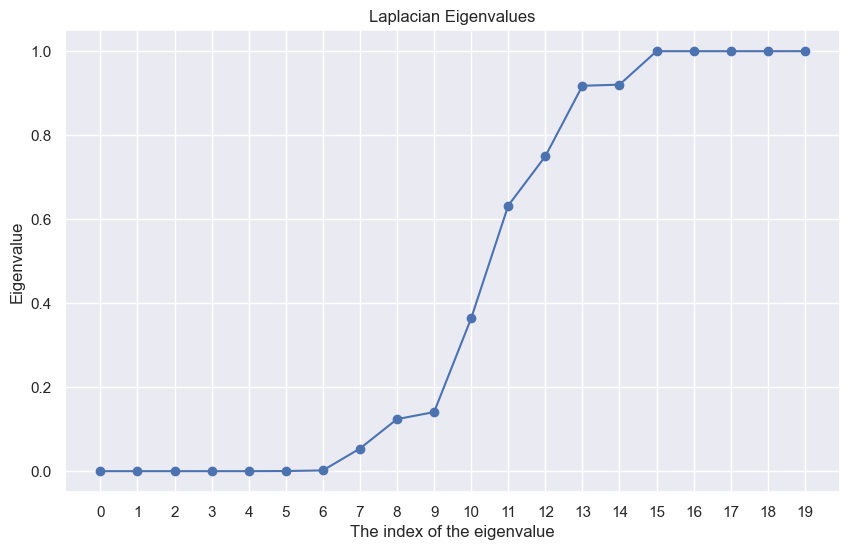

In [18]:
# Laplacian Eigenvalues plot
D = np.diag(np.sum(A, axis=1))
L= np.eye(A.shape[0]) - np.linalg.inv(np.sqrt(D)) @ A @ np.linalg.inv(np.sqrt(D))
eigenvalues, eigenvectors = eigh(L)

sorted_indices = np.argsort(eigenvalues)
eigenvalues_sorted = eigenvalues[sorted_indices]

plt.figure(figsize=(10, 6))
plt.plot(np.arange(0, min(20, len(eigenvalues_sorted))), 
            eigenvalues_sorted[1:21], 'bo-') 
plt.xticks(np.arange(0, min(20, len(eigenvalues_sorted)), 1))
plt.xlabel('The index of the eigenvalue')
plt.ylabel('Eigenvalue')
plt.title('Laplacian Eigenvalues')
plt.show()

In [19]:
eigengap = np.diff(eigenvalues_sorted[1:11])
optimal_k = np.argmax(eigengap) + 2 

eigen_df = pd.DataFrame({
    'Difference between Eigenvalues': eigengap,
    'Number of clusters': np.arange(2, 11)})  
eigen_df.style.highlight_max(subset=['Difference between Eigenvalues'], color='red')

eigen_df.T

,0,1,2,3,4,5,6,7,8
Difference between Eigenvalues,6.875757e-16,1.925212e-14,7.640218e-07,0.000062,0.000273,0.0014,0.052134,0.070024,0.016821
Number of clusters,2.000000e+00,3.000000e+00,4.000000e+00,5.000000,6.000000,7.0000,8.000000,9.000000,10.000000


In [20]:
# Spectral Clustering run
spectral = SpectralClustering(n_clusters=9, affinity='precomputed', random_state=42, 
                              assign_labels='kmeans')
y_spectral = spectral.fit_predict(A)

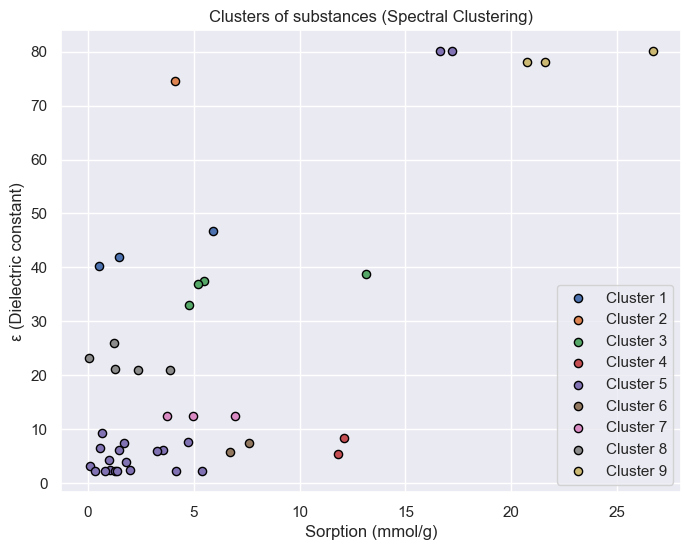

In [21]:
# Plotting the clusters for Spectral Clustering
plt.figure(figsize=(8,6))
plt.scatter(X[y_spectral == 0, 0], X[y_spectral == 0, 1], s = 35, label = 'Cluster 1', edgecolors='black')
plt.scatter(X[y_spectral == 1, 0], X[y_spectral == 1, 1], s = 35, label = 'Cluster 2', edgecolors='black')
plt.scatter(X[y_spectral == 2, 0], X[y_spectral == 2, 1], s = 35, label = 'Cluster 3',  edgecolors='black')
plt.scatter(X[y_spectral == 3, 0], X[y_spectral ==  3, 1], s = 35, label = 'Cluster 4', edgecolors='black')
plt.scatter(X[y_spectral == 4, 0], X[y_spectral == 4, 1], s = 35, label = 'Cluster 5', edgecolors='black')
plt.scatter(X[y_spectral == 5, 0], X[y_spectral == 5, 1], s = 35, label = 'Cluster 6', edgecolors='black')
plt.scatter(X[y_spectral == 6, 0], X[y_spectral == 6, 1], s = 35, label = 'Cluster 7', edgecolors='black')
plt.scatter(X[y_spectral == 7, 0], X[y_spectral == 7, 1], s = 35, label = 'Cluster 8', edgecolors='black')
plt.scatter(X[y_spectral == 8, 0], X[y_spectral == 8, 1], s = 35, label = 'Cluster 9', edgecolors='black')

plt.title('Clusters of substances (Spectral Clustering)')
plt.xlabel('Sorption (mmol/g)')
plt.ylabel('ε (Dielectric constant)')
plt.legend()

In [22]:
# Cluster DataFrame report for Spectral Clustering
df_spectral = cluster_df(y_spectral).sort_values('Cluster').reset_index(drop=True)
df_spectral

,Name,Cluster,ε (Dielectric constant),Sorption (mmol/g)
0,Dimethyl sulfoxide (DMSO),1,46.68,5.919
1,Citraconic anhydride,1,40.30,0.544
2,Furfural,1,42.00,1.472
3,Hydrogen peroxide,2,74.60,4.114
4,Acetonitrile-d3,3,37.50,5.495
5,N-Methyl-2-pyrrolidone (NMP),3,33.00,4.791
6,Dimethylformamide (DMF),3,37.00,5.192
7,Acetonitrile,3,38.80,13.154
8,Pyrrolidine,4,8.30,12.102
9,n-Butylamine,4,5.40,11.826


## 4. DBSCAN

DBSCAN is a density-based clustering method that groups together points that lie in dense regions of the data space. Instead of forcing every point into a cluster, it separates dense structures from scattered or noisy points. This makes the method useful when the data contain irregular shapes or many outliers.  
It requires two main parameters: the neighborhood radius and the minimum number of points that define a dense area. When these conditions are met, points expand into connected regions that form clusters. Everything that remains isolated is treated as noise.  
This approach helps reveal natural patterns in data without assuming how many clusters should exist beforehand.


In [23]:
# DBSCAN Clustering run with eps=6 and min_samples=3 as the optimal parameters found by hyperparameter tuning
dbscan = DBSCAN(eps=6, min_samples=3).fit(X)

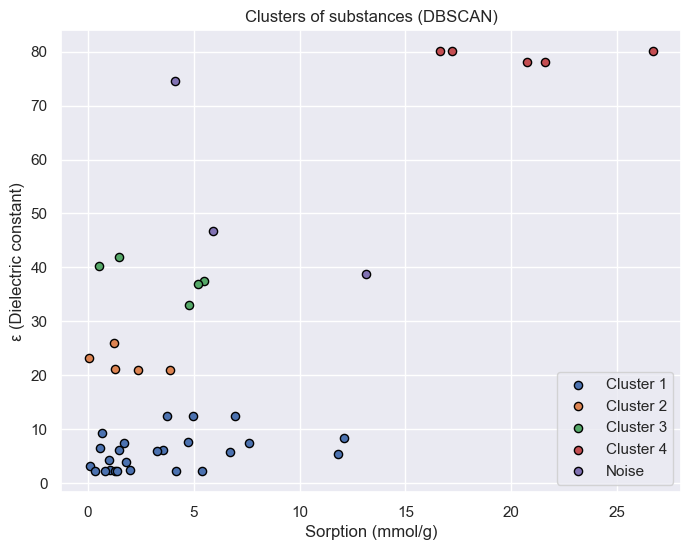

In [24]:
# DBSCAN cluster plotting
plt.figure(figsize=(8,6))
plt.scatter(X[dbscan.labels_ == 0, 0], X[dbscan.labels_ == 0, 1], s = 35, label = 'Cluster 1', edgecolors='black')
plt.scatter(X[dbscan.labels_ == 1, 0], X[dbscan.labels_ == 1, 1], s = 35, label = 'Cluster 2', edgecolors='black')  
plt.scatter(X[dbscan.labels_ == 2, 0], X[dbscan.labels_ == 2, 1], s = 35, label = 'Cluster 3', edgecolors='black')
plt.scatter(X[dbscan.labels_ == 3, 0], X[dbscan.labels_ == 3, 1], s = 35, label = 'Cluster 4', edgecolors='black')
plt.scatter(X[dbscan.labels_ == -1, 0], X[dbscan.labels_ == -1, 1], s = 35, label = 'Noise', edgecolors='black') 
plt.legend()
plt.title('Clusters of substances (DBSCAN)')
plt.xlabel('Sorption (mmol/g)')
plt.ylabel('ε (Dielectric constant)')
plt.show()

In [25]:
# DBSCAN Cluster DataFrame report
y_dbscan = dbscan.labels_
df_dbscan = cluster_df(y_dbscan).sort_values('Cluster').reset_index(drop=True)
df_dbscan

,Name,Cluster,ε (Dielectric constant),Sorption (mmol/g)
0,Hydrogen peroxide,0,74.60,4.114
1,Dimethyl sulfoxide (DMSO),0,46.68,5.919
2,Acetonitrile,0,38.80,13.154
3,Benzene-d6 (Deuterated benzene),1,2.28,1.395
4,Dibutyl phthalate,1,6.44,0.561
5,Dicyclohexylamine,1,2.27,0.332
6,"Limonene, D (R)",1,2.30,0.814
7,N-Methylaniline,1,6.06,1.455
8,Morpholine,1,7.40,7.618
9,"1,4-Dioxane",1,2.20,5.392


## Internal Cluster Validation

To compare the clustering methods, we used three internal validation metrics: **Silhouette**, **Calinski–Harabasz**, and **Davies–Bouldin**.  
These metrics help evaluate how well the clusters are formed without needing external labels.

### 1) Silhouette Score
Silhouette measures how similar a point is to its own cluster compared to other clusters.

$
s = \frac{b - a}{\max(a, b)}
$

- $a$: average distance to points in the same cluster  
- $b$: lowest average distance to points in other clusters  
- Values range from $-1$ to $1$. Higher is better.

### 2) Calinski–Harabasz Index
This score compares the dispersion between clusters to the dispersion inside clusters.

$
CH = \frac{SS_B/(k-1)}{SS_W/(n-k)}
$

- $SS_B$: between-cluster dispersion  
- $SS_W$: within-cluster dispersion  
- Higher values mean better clustering.

### 3) Davies–Bouldin Index
This index measures how well clusters are separated.

$
DB = \frac{1}{k} \sum_{i=1}^{k} \max_{j \neq i} 
\left( \frac{s_i + s_j}{d_{ij}} \right)
$

- $s_i$: average distance of points in cluster \(i\) to its center  
- $d_{ij}$: distance between cluster centers  
- Lower values are better.


In [26]:
metrics_df = pd.DataFrame({
    'Method': ['K-Means', 'Hierarchical', 'Spectral', 'DBSCAN'],
    'Silhouette': [silhouette_score(X, y_kmeans), silhouette_score(X, y_hc), silhouette_score(X, y_spectral), silhouette_score(X, y_dbscan)],
    'Calinski-Harabasz': [calinski_harabasz_score(X, y_kmeans), calinski_harabasz_score(X,y_hc), calinski_harabasz_score(X, y_spectral), calinski_harabasz_score(X,y_dbscan)],
    'Davies-Bouldin': [davies_bouldin_score(X,y_kmeans), davies_bouldin_score(X,y_hc), davies_bouldin_score(X, y_spectral), davies_bouldin_score(X, y_dbscan)]
})

In [27]:
metrics_df.round(2)

,Method,Silhouette,Calinski-Harabasz,Davies-Bouldin
0,K-Means,0.61,328.85,0.50
1,Hierarchical,0.70,285.95,0.43
2,Spectral,0.06,7.30,2.70
3,DBSCAN,0.60,185.67,0.76


## 6. RANSAC Regression to find linear similarities within the clusters

The main idea of the RANdom SAmple Consensus method is to find the best linear relationships within the data. Based on a random sample of points and an estimate of the model parameters, a set of consistent points is constructed that fall within the threshold value. The threshold value can be selected manually, as well as calculated based on finding the median absolute deviation or from the standard deviation of the data. The value equal to 1 for all models was chosen as a single threshold parameter. The search for linear correlations was launched for all clustering methods. The pipeline for these methods is shown below.

In [28]:
# plotting the RANSAC for different methods
def ransac_plot(X, y, threshold, n, m, size_inliers, size_outliers, legend_fontsize):                     
    X_arr = np.asarray(X).reshape(-1, 1)      
    y_arr = np.asarray(y).ravel()
    try:
        ax_curr = ax[n, m]         
    except:
        ax_curr = ax[m]  

    ransacReg = RANSACRegressor(LinearRegression(), residual_threshold=threshold, random_state=0)
    ransacReg.fit(X_arr, y_arr)

    inlier_mask = ransacReg.inlier_mask_
    outlier_mask = ~inlier_mask

    x_line = np.linspace(X_arr.min(), X_arr.max(), 200).reshape(-1, 1)
    
    y_line = ransacReg.predict(x_line)

        
    if inlier_mask.sum() > 1:
        r2_inliers = ransacReg.estimator_.score(X_arr[inlier_mask].reshape(-1,1), y_arr[inlier_mask])
    else:
        r2_inliers = ransacReg.score(X_arr, y_arr)  

    
    ax_curr.plot(x_line.ravel(), y_line.ravel(), color='black', linestyle='--',
                 label=f'Fit: y = {ransacReg.estimator_.coef_[0]:.2f}x + {ransacReg.estimator_.intercept_:.1f}\n$R^2_{{inlier}}$= {r2_inliers:.3f}')
    ax_curr.scatter(X_arr[inlier_mask], y_arr[inlier_mask], facecolors='none', edgecolors='k',
                    s=size_inliers, linewidths=1.2, label='Inliers')
    ax_curr.scatter(X_arr[outlier_mask], y_arr[outlier_mask], facecolors='gray', edgecolors='k',
                    alpha=0.6, s=size_outliers, label='Outliers')

    ax_curr.legend(fontsize=legend_fontsize, loc='best')



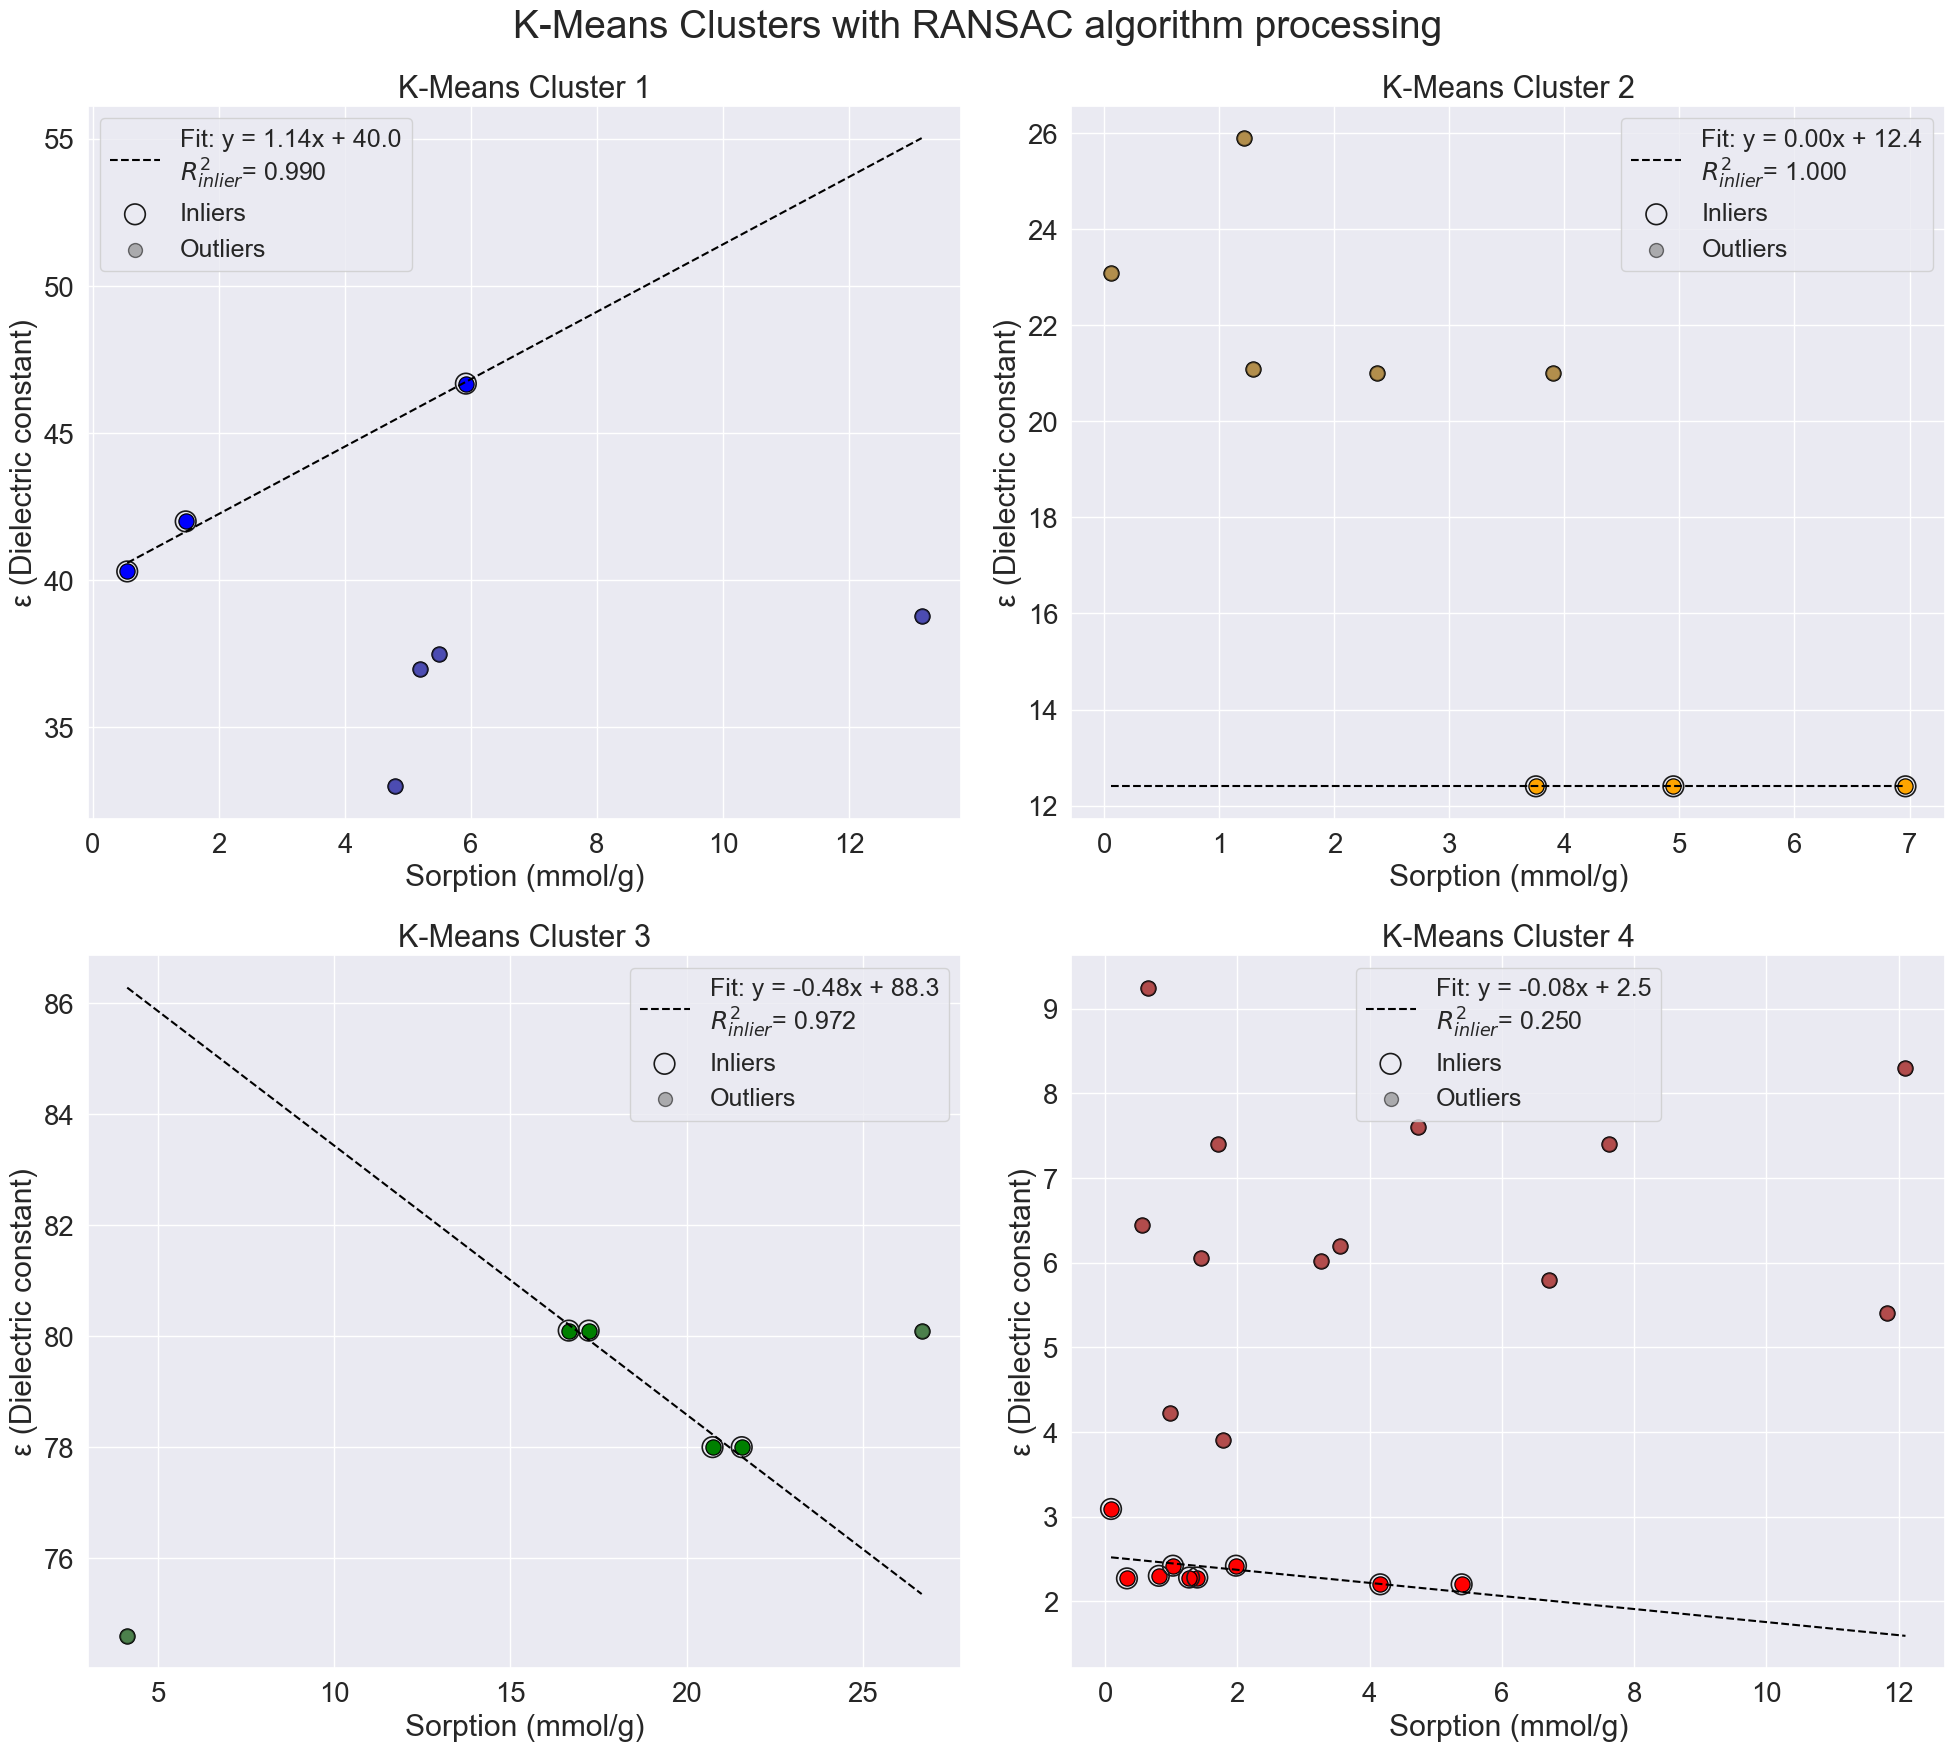

In [29]:
sns.set(font_scale=1.8)
fig, ax = plt.subplots(2,2, figsize=(20,18))
sns.scatterplot(ax=ax[0,0], x = 'Sorption (mmol/g)', y = 'ε (Dielectric constant)', 
                data=df_kmeans.loc[df_kmeans['Cluster']=='1'], color='blue', edgecolor='black', s = 120)
sns.scatterplot(ax=ax[0,1], x = 'Sorption (mmol/g)', y = 'ε (Dielectric constant)'
                , data=df_kmeans.loc[df_kmeans['Cluster']=='2'], color='orange', edgecolor='black', s = 120)
sns.scatterplot(ax=ax[1,0], x = 'Sorption (mmol/g)', y = 'ε (Dielectric constant)',
                 data=df_kmeans.loc[df_kmeans['Cluster']=='3'], color ='green', edgecolor='black', s = 120)
sns.scatterplot(ax=ax[1,1], x = 'Sorption (mmol/g)', y = 'ε (Dielectric constant)', 
                data=df_kmeans.loc[df_kmeans['Cluster']=='4'], color='red', edgecolor='black', s = 120)
for i, cluster in enumerate(['1', '2', '3', '4']):
    df_cluster = df_kmeans[df_kmeans['Cluster'] == cluster]
    ransac_plot(df_cluster['Sorption (mmol/g)'], df_cluster['ε (Dielectric constant)'], threshold=1.0, n=i//2, m=i%2,
                size_inliers=220, size_outliers=100, legend_fontsize=18)

ax[0,0].set_title('K-Means Cluster 1', fontsize=22)
ax[0,1].set_title('K-Means Cluster 2', fontsize=22)
ax[1,0].set_title('K-Means Cluster 3', fontsize=22)
ax[1,1].set_title('K-Means Cluster 4', fontsize=22)

plt.suptitle('K-Means Clusters with RANSAC algorithm processing', fontsize=28)
plt.tight_layout()


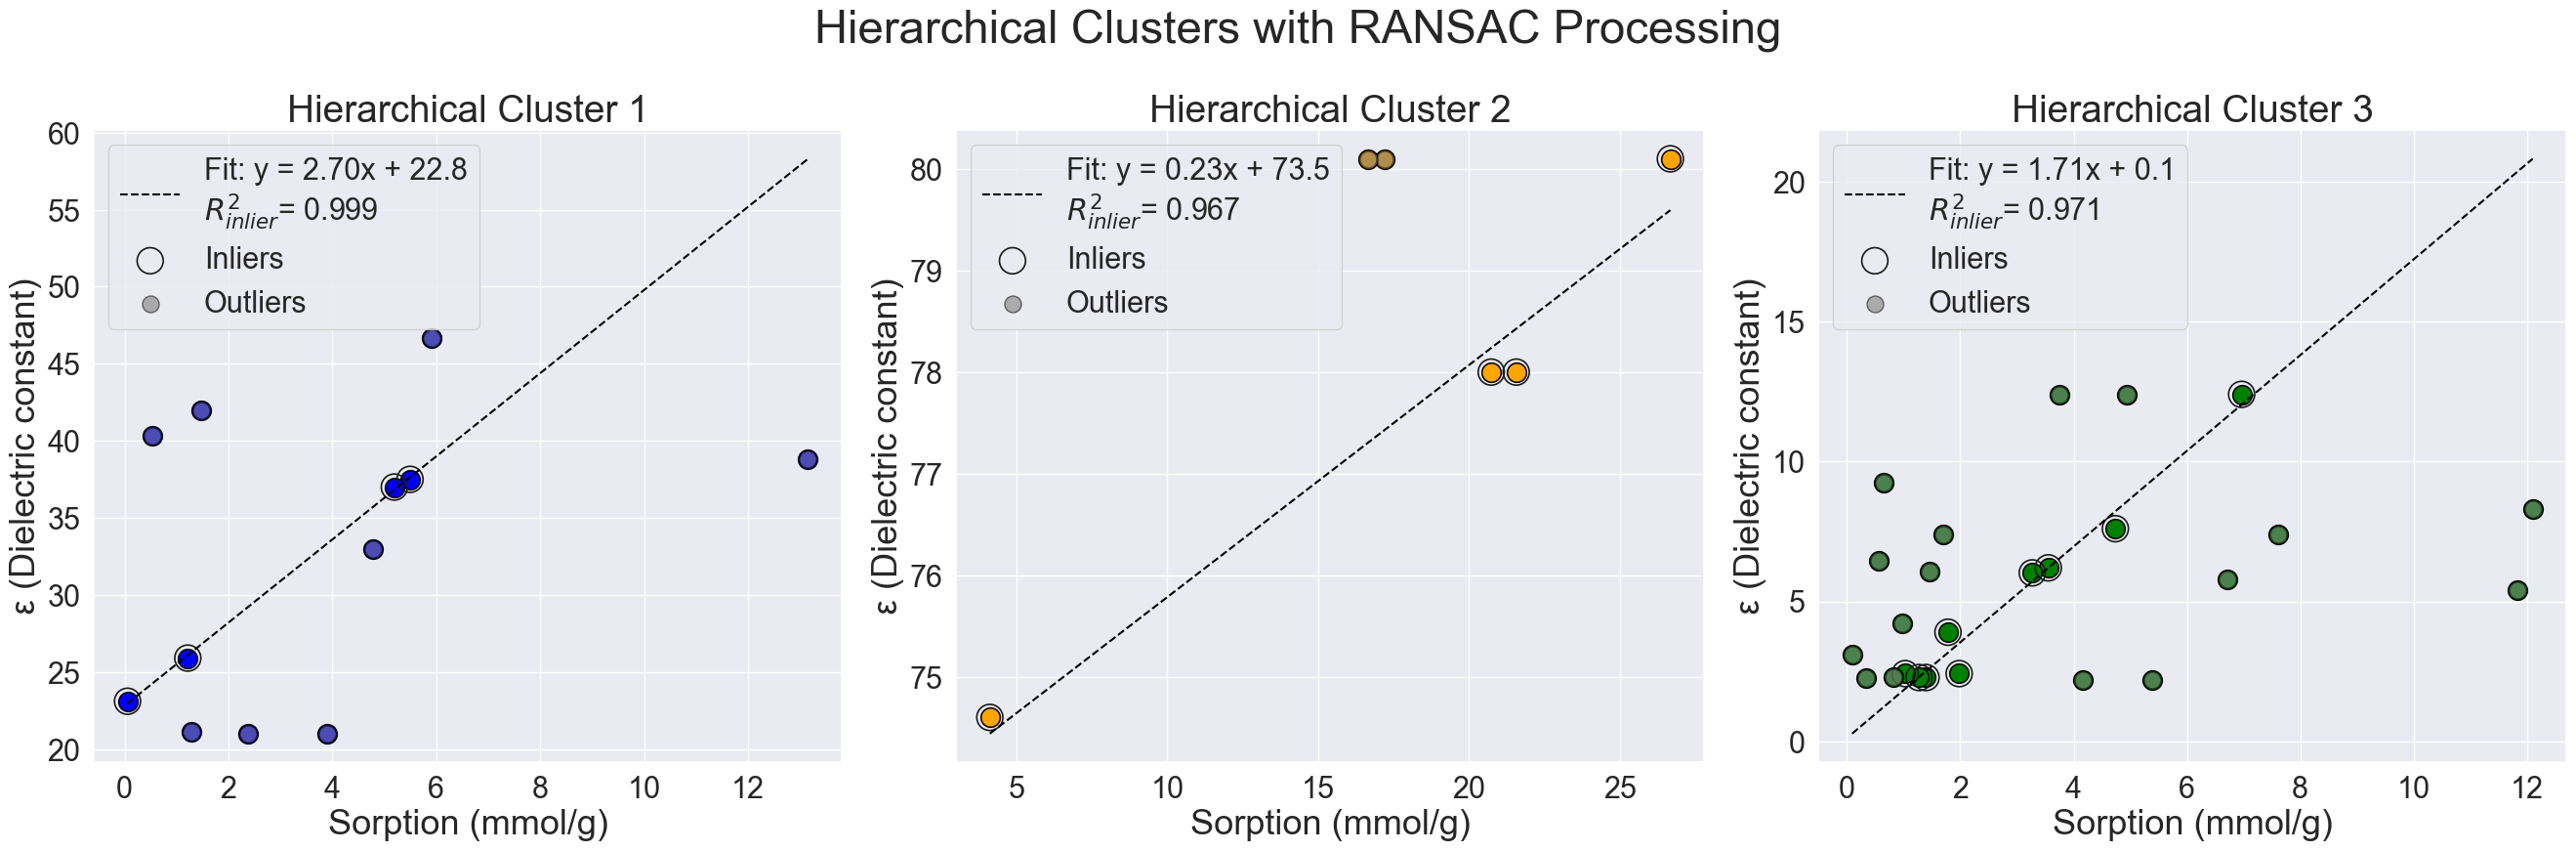

In [30]:
sns.set(font_scale=1.7)
fig, ax = plt.subplots(1, 3, figsize=(27, 9))


sns.scatterplot(ax=ax[0], x='Sorption (mmol/g)', y='ε (Dielectric constant)',
                data=df_hc[df_hc['Cluster']=='1'], color='blue',
                edgecolor='black', s=200)

sns.scatterplot(ax=ax[1], x='Sorption (mmol/g)', y='ε (Dielectric constant)',
                data=df_hc[df_hc['Cluster']=='2'], color='orange',
                edgecolor='black', s=200)

sns.scatterplot(ax=ax[2], x='Sorption (mmol/g)', y='ε (Dielectric constant)',
                data=df_hc[df_hc['Cluster']=='3'], color='green',
                edgecolor='black', s=200)


for i, cluster in enumerate(['1', '2', '3']):
    df_cluster = df_hc[df_hc['Cluster'] == cluster]
    ransac_plot(df_cluster['Sorption (mmol/g)'],
                df_cluster['ε (Dielectric constant)'],
                threshold=1.0, n=0, m=i, size_inliers=370, size_outliers=150, legend_fontsize=22)

ax[0].set_title('Hierarchical Cluster 1', fontsize=28)
ax[1].set_title('Hierarchical Cluster 2', fontsize=28)
ax[2].set_title('Hierarchical Cluster 3', fontsize=28)

for a in ax:
    a.set_xlabel(a.get_xlabel(), fontsize=26)
    a.set_ylabel(a.get_ylabel(), fontsize=26)
    a.tick_params(axis='both', which='major', labelsize=22)

plt.suptitle('Hierarchical Clusters with RANSAC Processing', fontsize=34)
plt.tight_layout()
plt.show()

Cluster 2: contains too few points (1) — skipping
Cluster 4: contains too few points (2) — skipping
Cluster 6: contains too few points (2) — skipping


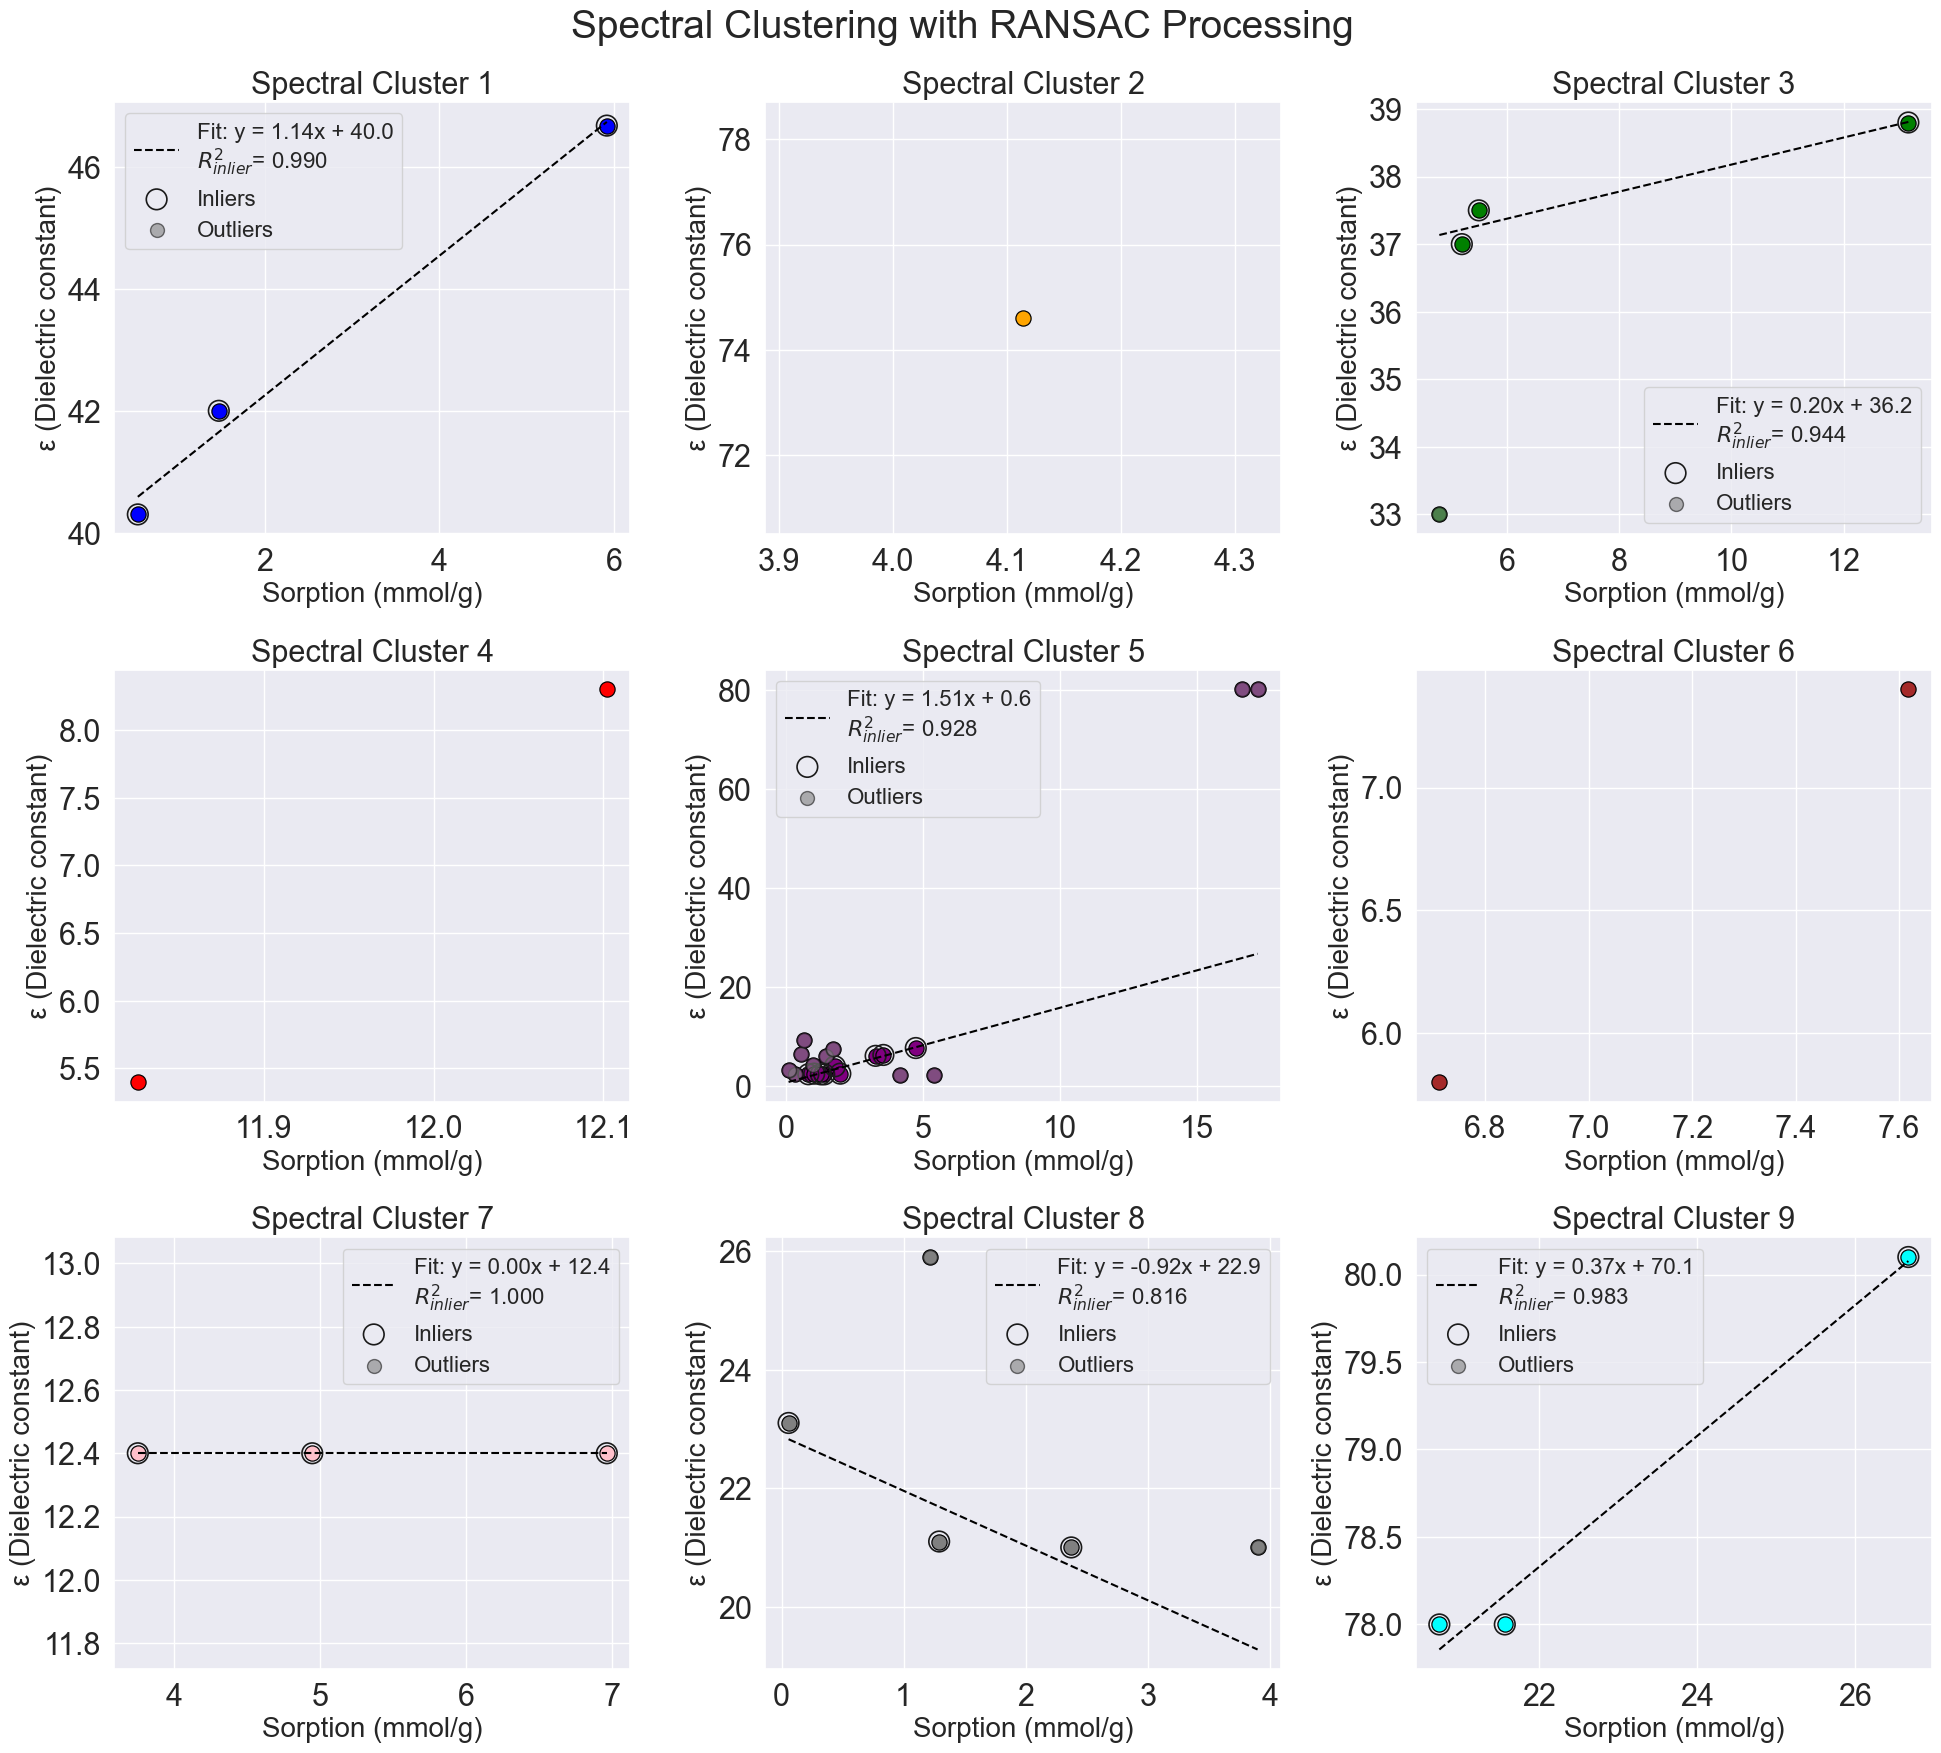

In [31]:
fig, ax = plt.subplots(3,3, figsize=(20,18))
sns.scatterplot(ax=ax[0,0], x = 'Sorption (mmol/g)', y = 'ε (Dielectric constant)', 
                data=df_spectral.loc[df_spectral['Cluster']=='1'], color='blue', edgecolor='black', s = 120)
sns.scatterplot(ax=ax[0,1], x = 'Sorption (mmol/g)', y = 'ε (Dielectric constant)',
                data=df_spectral.loc[df_spectral['Cluster']=='2'], color='orange', edgecolor='black', s = 120)
sns.scatterplot(ax=ax[0,2], x = 'Sorption (mmol/g)', y = 'ε (Dielectric constant)',
                 data=df_spectral.loc[df_spectral['Cluster']=='3'], color ='green', edgecolor='black', s = 120)
sns.scatterplot(ax=ax[1,0], x = 'Sorption (mmol/g)', y = 'ε (Dielectric constant)', 
                data=df_spectral.loc[df_spectral['Cluster']=='4'], color='red', edgecolor='black', s = 120)
sns.scatterplot(ax=ax[1,1], x = 'Sorption (mmol/g)', y = 'ε (Dielectric constant)',
                data=df_spectral.loc[df_spectral['Cluster']=='5'], color='purple', edgecolor='black', s = 120)
sns.scatterplot(ax=ax[1,2], x = 'Sorption (mmol/g)', y = 'ε (Dielectric constant)',
                 data=df_spectral.loc[df_spectral['Cluster']=='6'], color ='brown', edgecolor='black', s = 120)
sns.scatterplot(ax=ax[2,0], x = 'Sorption (mmol/g)', y = 'ε (Dielectric constant)', 
                data=df_spectral.loc[df_spectral['Cluster']=='7'], color='pink', edgecolor='black', s = 120)
sns.scatterplot(ax=ax[2,1], x = 'Sorption (mmol/g)', y = 'ε (Dielectric constant)',
                data=df_spectral.loc[df_spectral['Cluster']=='8'], color='gray', edgecolor='black', s = 120)
sns.scatterplot(ax=ax[2,2], x = 'Sorption (mmol/g)', y = 'ε (Dielectric constant)',
                data=df_spectral.loc[df_spectral['Cluster']=='9'], color='cyan', edgecolor='black', s = 120)

for i, cluster in enumerate(['1', '2', '3', '4', '5', '6', '7', '8', '9']):
    df_cluster = df_spectral[df_spectral['Cluster'] == cluster]
    if len(df_cluster) < 3:
        print(f"Cluster {cluster}: contains too few points ({len(df_cluster)}) — skipping")
        continue
    ransac_plot(df_cluster['Sorption (mmol/g)'], df_cluster['ε (Dielectric constant)'], threshold=1, n=i//3, m=i%3,
                size_inliers=220, size_outliers=100, legend_fontsize=16)
for i in range(3):
    for j in range(3):
        ax[i,j].set_xlabel(ax[i,j].get_xlabel(), fontsize=20)
        ax[i,j].set_ylabel(ax[i,j].get_ylabel(), fontsize=20)
        ax[i,j].tick_params(axis='both', which='major', labelsize=22)
        ax[i,j].set_title(f"Spectral Cluster {3*i+j+1}", fontsize=22)
plt.suptitle('Spectral Clustering with RANSAC Processing', fontsize=28)
plt.tight_layout()

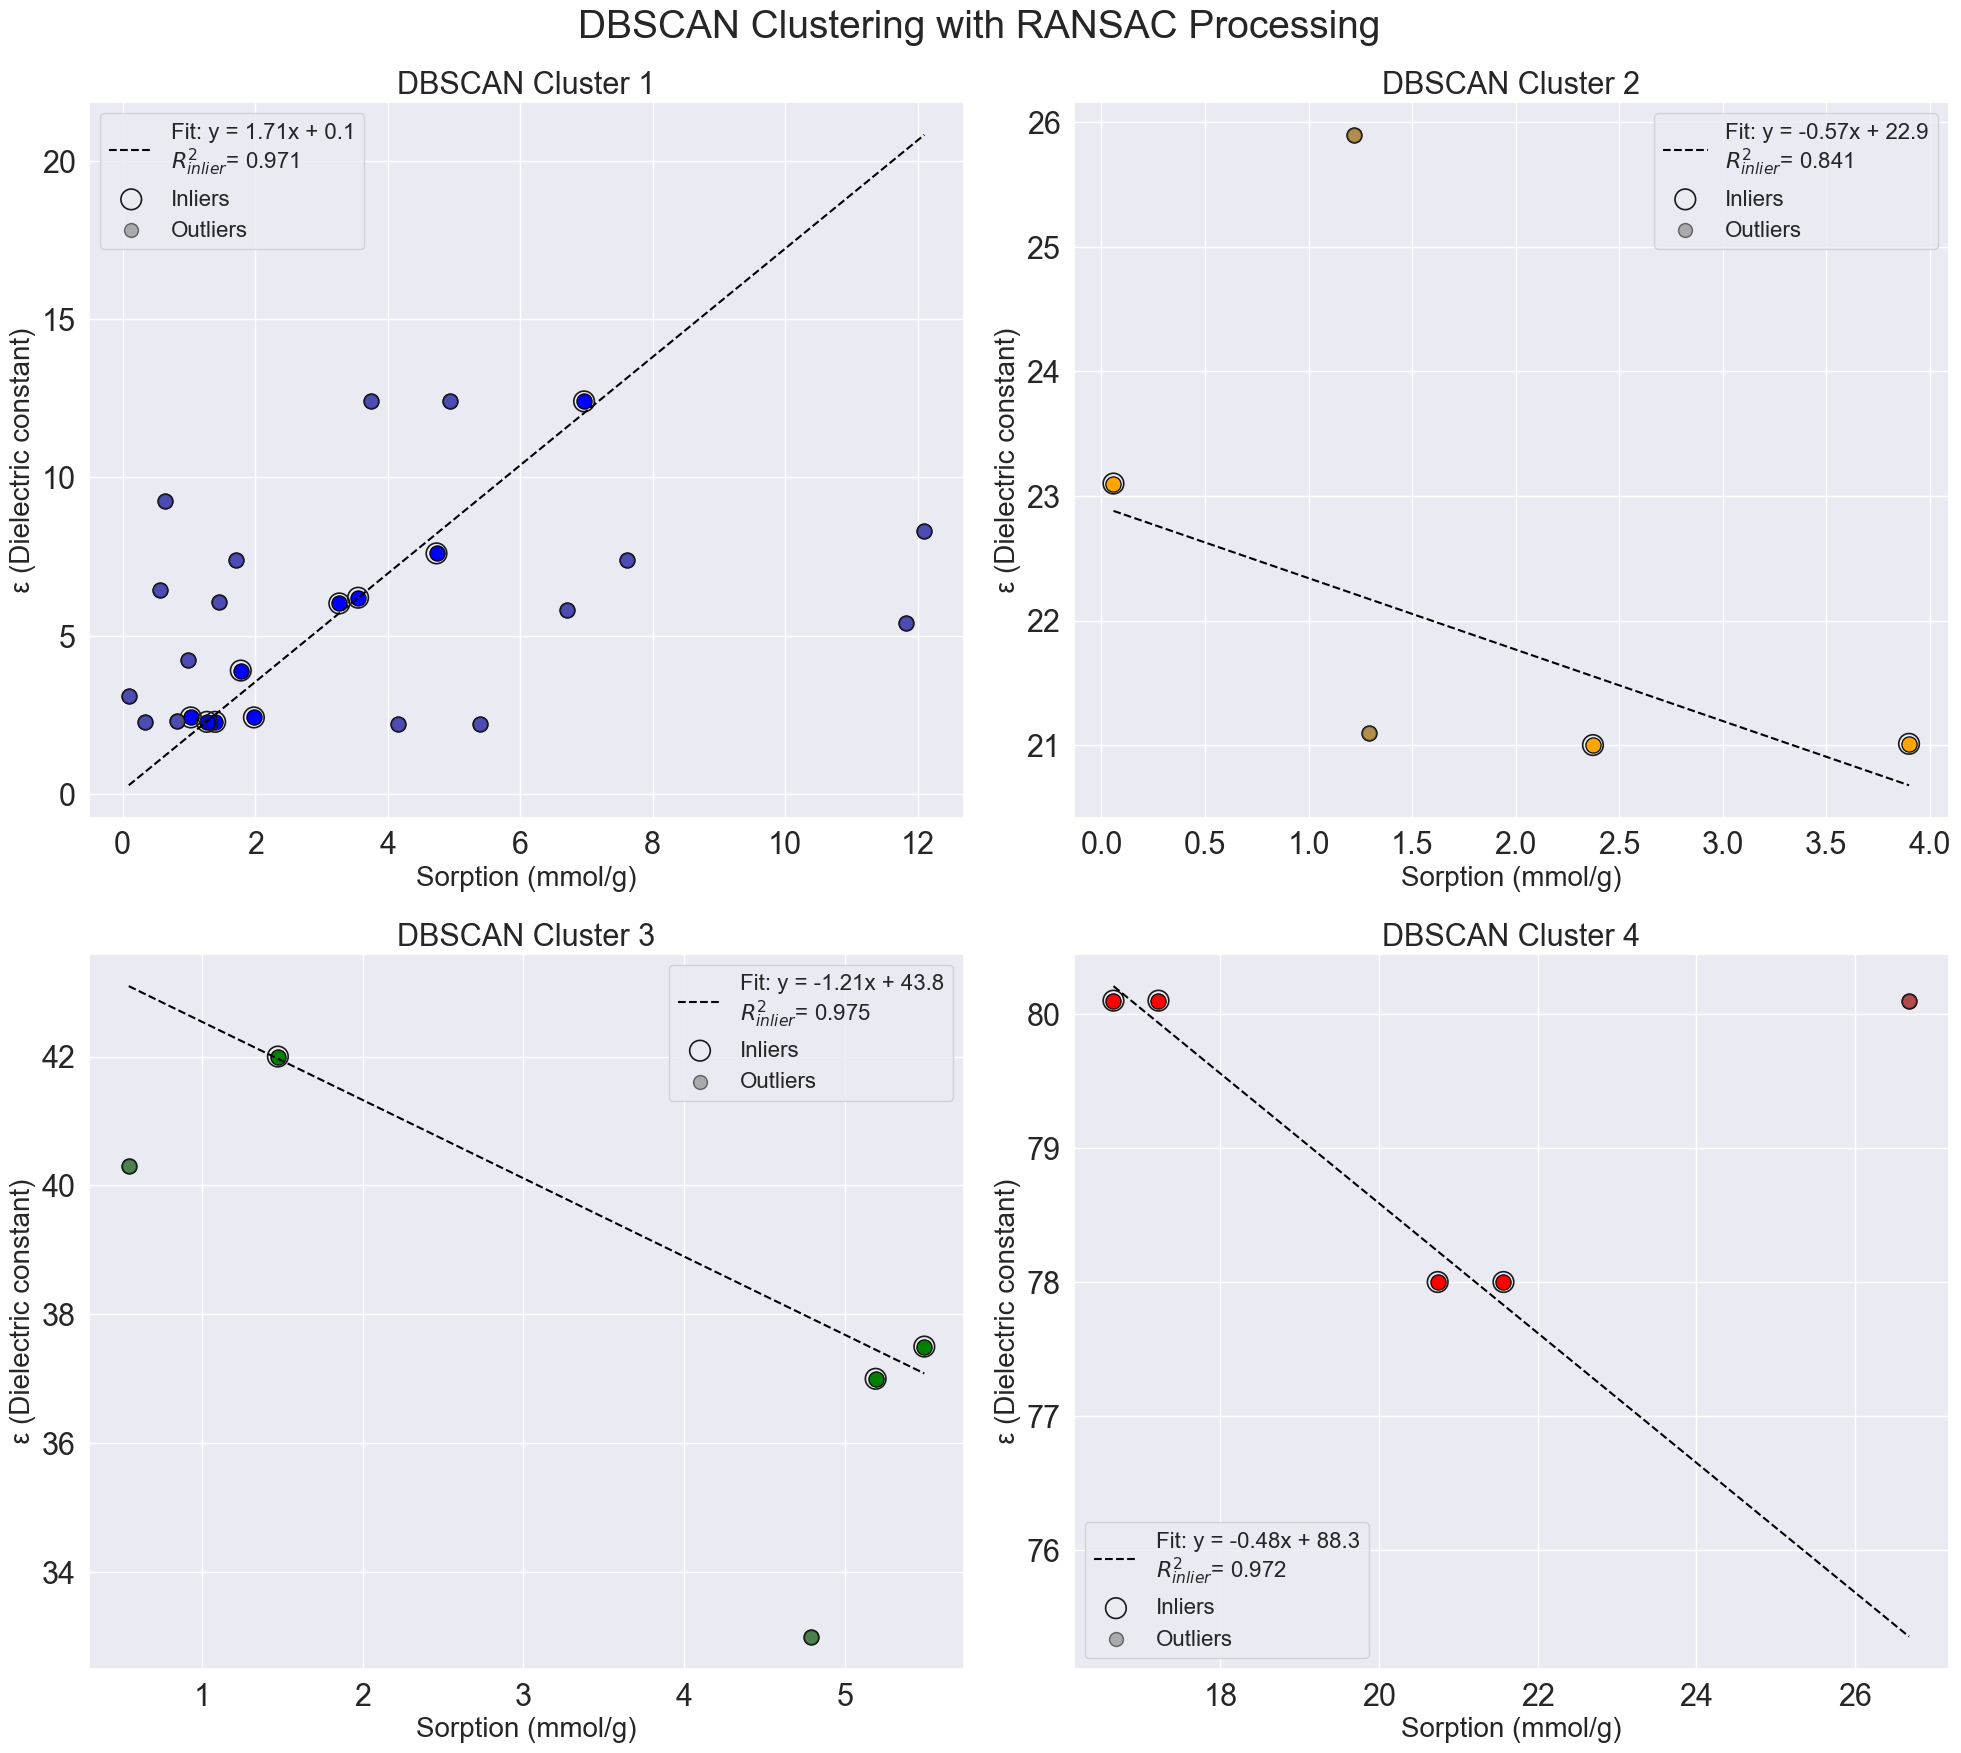

In [32]:
fix, ax = plt.subplots(2,2, figsize=(20,18))
sns.scatterplot(ax=ax[0,0], x = 'Sorption (mmol/g)', y = 'ε (Dielectric constant)', 
                data=df_dbscan.loc[df_dbscan['Cluster']=='1'], color='blue', edgecolor='black', s = 120)
sns.scatterplot(ax=ax[0,1], x = 'Sorption (mmol/g)', y = 'ε (Dielectric constant)',
                data=df_dbscan.loc[df_dbscan['Cluster']=='2'], color='orange', edgecolor='black', s = 120)
sns.scatterplot(ax=ax[1,0], x = 'Sorption (mmol/g)', y = 'ε (Dielectric constant)',
                 data=df_dbscan.loc[df_dbscan['Cluster']=='3'], color ='green', edgecolor='black', s = 120)
sns.scatterplot(ax=ax[1,1], x = 'Sorption (mmol/g)', y = 'ε (Dielectric constant)', 
                data=df_dbscan.loc[df_dbscan['Cluster']=='4'], color='red', edgecolor='black', s = 120)
for i, cluster in enumerate(['1', '2', '3', '4']):
    df_cluster = df_dbscan[df_dbscan['Cluster'] == cluster]
    if len(df_cluster) < 3:
        print(f"Cluster {cluster}: contains too few points ({len(df_cluster)}) — skipping")
        continue
    ransac_plot(df_cluster['Sorption (mmol/g)'], df_cluster['ε (Dielectric constant)'], threshold=1, n=i//2, m=i%2,
                size_inliers=220, size_outliers=100, legend_fontsize=16)
for i in range(2):
    for j in range(2):
        ax[i,j].set_xlabel(ax[i,j].get_xlabel(), fontsize=20)
        ax[i,j].set_ylabel(ax[i,j].get_ylabel(), fontsize=20)
        ax[i,j].tick_params(axis='both', which='major', labelsize=22)
        ax[i,j].set_title(f"DBSCAN Cluster {2*i+j+1}", fontsize=22)
plt.suptitle('DBSCAN Clustering with RANSAC Processing', fontsize=28)
plt.tight_layout()

## 7. Sequential RANSAC

Since our data are of physico-chemical importance, for some clusters containing a large number of compounds, it is necessary to find several linear correlations in order to thoroughly study the hypothesis of chemisorption of solvents on graphene oxide. In addition, we will tighten the algorithm by allowing it to search only for positively correlated points with a high correlation coefficient, with several dependencies. This method is referred to in the literature as ***sequential RANSAC***. In the next pipeline, you can observe the implementation of the ```sequantial_ransac``` function as a pipeline for searching for linear correlations in data. 


**Attention**: for the implementation of sequential RANSAC, only some clusters from the three most meaningful and qualitative clustering methods were extracted. Spectral clustering proved unsatisfactory on our data.

- The standard value of one was taken as the ```threshold``` value. Selecting this value based on the distribution of data in the cluster did not result in significant improvements.

- The value 0.65 was taken as the threshold coefficient of determination.

- The agglorhythm processes many iterations to find the maximum number of correlating points. 

- After that, each method is accompanied by a summary and an inlier list.

### 7.1. Sequential RANSAC plots

In [33]:
# Sequential_ransac 
def sequential_ransac(
    X, y, threshold,sizes, n_iterations, ax = ax,
    markers=['o','s','^','D','P','X','v','<','>'], 
    colors=plt.rcParams['axes.prop_cycle'].by_key()['color'],
    legend_fontsize=10, min_inliers=3, min_r2=0.6, text_offset=None):

    ax = plt.gca() if ax is None else ax

    X_arr = np.asarray(X).reshape(-1, 1).astype(float)
    y_arr = np.asarray(y).ravel().astype(float)

    remaining_idx = np.arange(X_arr.shape[0])
    models = []
    rank_counter = 1
    y_range = (y_arr.max() - y_arr.min()) if (y_arr.max() - y_arr.min()) != 0 else 1.0
    text_offset = 0.025 * y_range if text_offset is None else text_offset * y_range

    for i in range(n_iterations):
        if remaining_idx.size < min_inliers:
            break

        X_rem = X_arr[remaining_idx]
        y_rem = y_arr[remaining_idx]

        ransac = RANSACRegressor(residual_threshold=1,random_state=0)
        try:
            ransac.fit(X_rem, y_rem)
        except Exception:
            break
        inlier_mask = ransac.inlier_mask_

        if inlier_mask.sum() < min_inliers:
            remaining_idx = remaining_idx[~inlier_mask]
            continue

        inliers_idx = remaining_idx[inlier_mask]
        coef = float(ransac.estimator_.coef_[0])
        r2 = float(ransac.score(X_rem[inlier_mask].reshape(-1,1), y_rem[inlier_mask]))

        if coef > 0 and r2 >= min_r2:
            x_line = np.linspace(X_arr.min(), X_arr.max(), 200).reshape(-1, 1)
            y_line = ransac.predict(x_line)

            color = colors[i % len(colors)]
            marker = markers[i % len(markers)]
            size = sizes[i % len(sizes)]

            ax.plot(
                x_line.ravel(), y_line.ravel(),
                linestyle='--', linewidth=2, color=color,
                label=f'$slope$ = {coef:.2f}, $R^2_{{inlier}}$= {r2:.2f}'
            )

            ax.scatter(
                X_arr[inliers_idx].ravel(), y_arr[inliers_idx],
                marker=marker, s=size, color=color,
                edgecolors='black', linewidths=1.2,
                label=f'$n_{{inliers}}$ = {inlier_mask.sum()}'
            )

            for j, idx in enumerate(inliers_idx):
                rank = rank_counter + j
                ax.text(
                    float(X_arr[idx]), float(y_arr[idx] + text_offset),
                    str(rank),
                    fontsize=9, ha='center', va='bottom', color='black'
                )

            models.append({
                'model': ransac,
                'inliers_idx': inliers_idx.copy(),
                'r2': r2,
                'slope': coef,
                'ranks': list(range(rank_counter, rank_counter + inliers_idx.size))
            })

            rank_counter += inliers_idx.size

        remaining_idx = remaining_idx[~inlier_mask]

    ax.legend(fontsize=legend_fontsize)
    return models


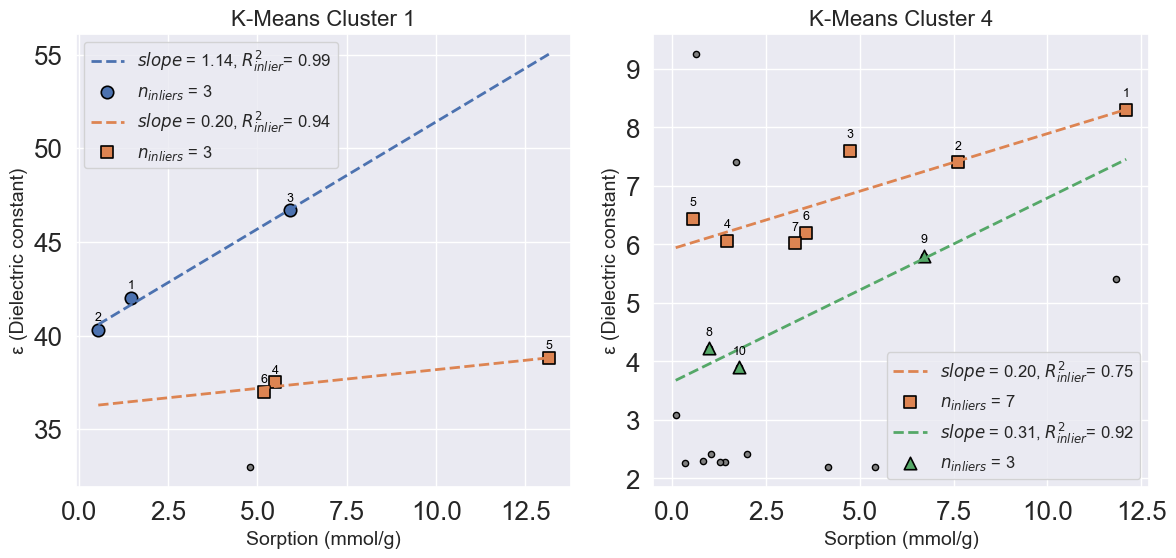

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for ax, cluster in zip(axes, ['1', '4']):
    dfc = df_kmeans[df_kmeans['Cluster'] == cluster]

    ax.scatter(
        dfc['Sorption (mmol/g)'],
        dfc['ε (Dielectric constant)'],
        s=20,
        color='gray',
        edgecolors='black'
    )

    sequential_ransac(
        dfc['Sorption (mmol/g)'],
        dfc['ε (Dielectric constant)'],
        n_iterations=10,
        ax=ax,
        threshold=1,
        legend_fontsize=12,
        min_inliers=3,
        sizes=[80]*9
    )

    ax.set_xlabel('Sorption (mmol/g)', fontsize=14)
    ax.set_ylabel('ε (Dielectric constant)', fontsize=14)
    ax.set_title(f'K-Means Cluster {cluster}', fontsize=16)

plt.tight_layout()
plt.show()


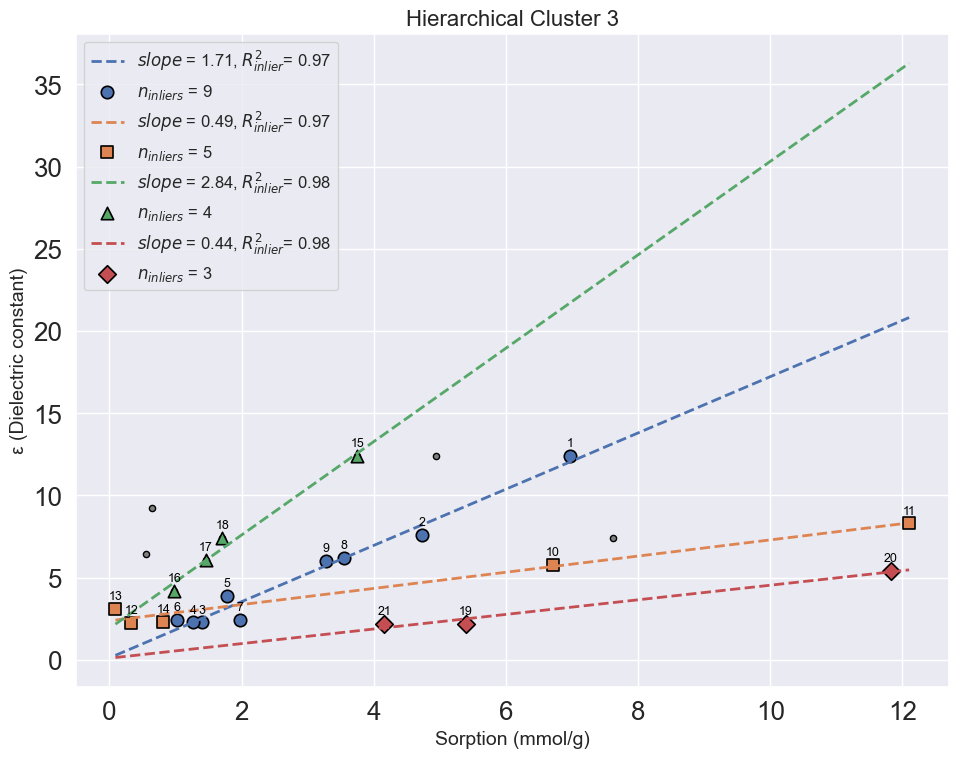

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

cluster = '3'
dfc = df_hc[df_hc['Cluster'].astype(str) == cluster]

ax.scatter(
    dfc['Sorption (mmol/g)'],
    dfc['ε (Dielectric constant)'],
    s=20,
    color='gray',
    edgecolors='black'
)

sequential_ransac(
    dfc['Sorption (mmol/g)'],
    dfc['ε (Dielectric constant)'],
    n_iterations=10,
    ax=ax,
    threshold=1,
    legend_fontsize=12,
    text_offset=0.04,
    min_inliers=3,
    sizes=[80]*9
)

ax.set_xlabel('Sorption (mmol/g)', fontsize=14)
ax.set_ylabel('ε (Dielectric constant)', fontsize=14)
ax.set_title(f'Hierarchical Cluster {cluster}', fontsize=16)

plt.tight_layout()
plt.show()


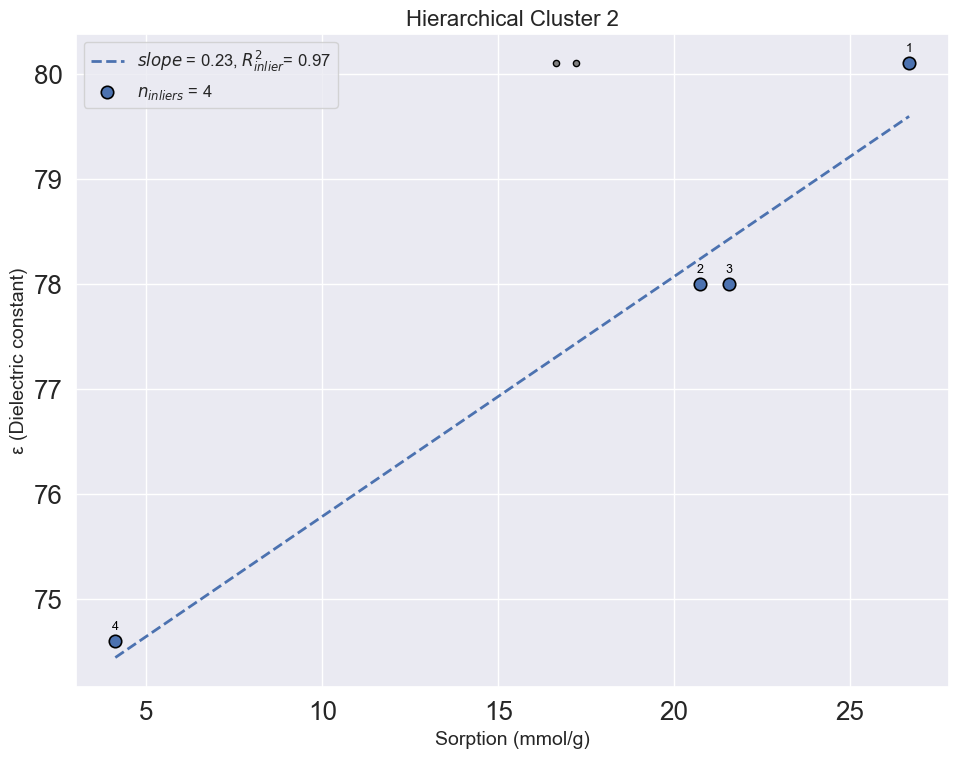

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

cluster = '2'
dfc = df_hc[df_hc['Cluster'].astype(str) == cluster]

ax.scatter(
    dfc['Sorption (mmol/g)'],
    dfc['ε (Dielectric constant)'],
    s=20,
    color='gray',
    edgecolors='black'
)

sequential_ransac(
    dfc['Sorption (mmol/g)'],
    dfc['ε (Dielectric constant)'],
    n_iterations=10,
    ax=ax,
    threshold=1,
    legend_fontsize=12,
    text_offset=0.015,
    min_inliers=3,
    sizes=[80]*9
)

ax.set_xlabel('Sorption (mmol/g)', fontsize=14)
ax.set_ylabel('ε (Dielectric constant)', fontsize=14)
ax.set_title(f'Hierarchical Cluster {cluster}', fontsize=16)

plt.tight_layout()
plt.show()



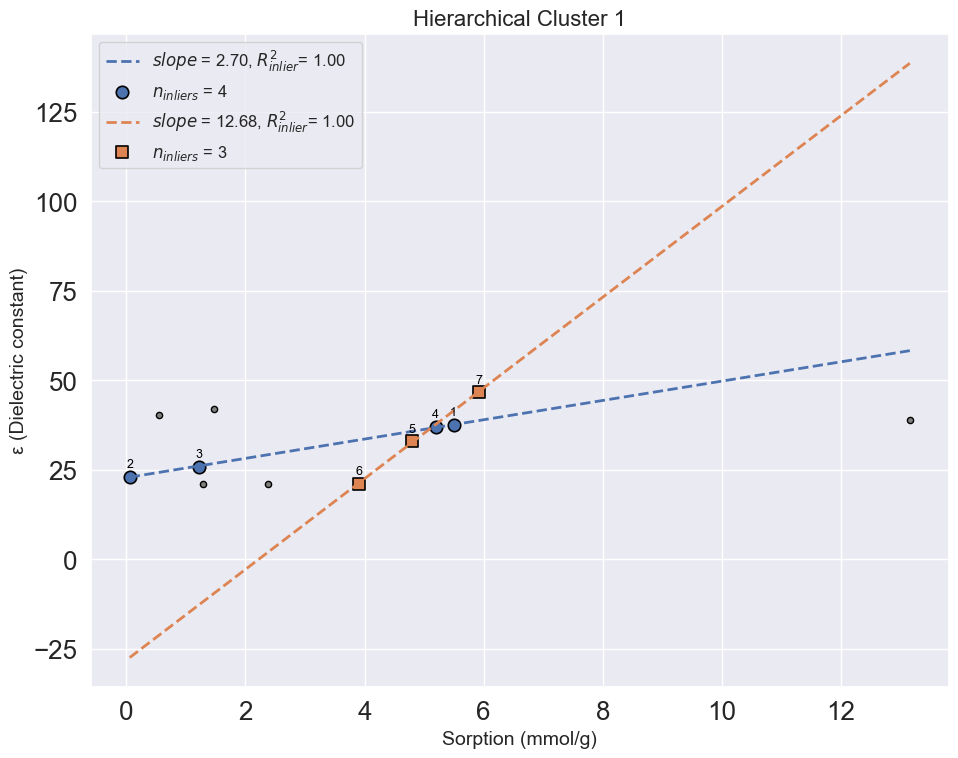

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

cluster = '1'
dfc = df_hc[df_hc['Cluster'].astype(str) == cluster]

ax.scatter(
    dfc['Sorption (mmol/g)'],
    dfc['ε (Dielectric constant)'],
    s=20,
    color='gray',
    edgecolors='black'
)

sequential_ransac(
    dfc['Sorption (mmol/g)'],
    dfc['ε (Dielectric constant)'],
    n_iterations=10,
    ax=ax,
    threshold=1,
    legend_fontsize=12,
    text_offset=0.07,
    min_inliers=3,
    sizes=[80]*9
)

ax.set_xlabel('Sorption (mmol/g)', fontsize=14)
ax.set_ylabel('ε (Dielectric constant)', fontsize=14)
ax.set_title(f'Hierarchical Cluster {cluster}', fontsize=16)

plt.tight_layout()
plt.show()


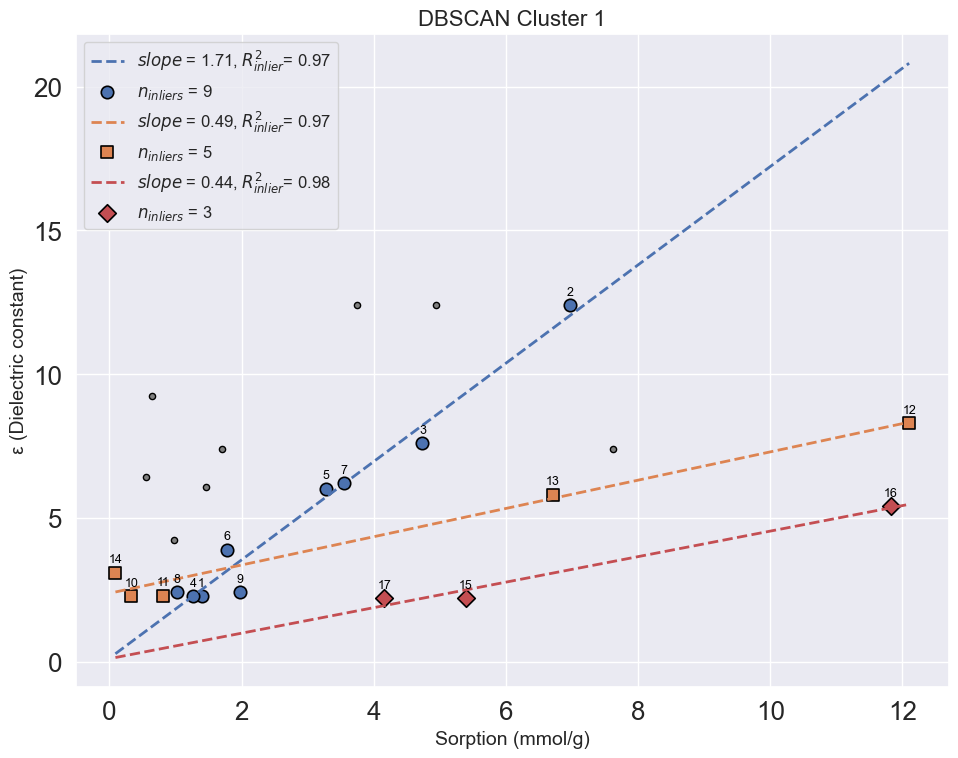

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

cluster = '1'
dfc = df_dbscan[df_dbscan['Cluster'].astype(str) == cluster]

ax.scatter(
    dfc['Sorption (mmol/g)'],
    dfc['ε (Dielectric constant)'],
    s=20,
    color='gray',
    edgecolors='black'
)

sequential_ransac(
    dfc['Sorption (mmol/g)'],
    dfc['ε (Dielectric constant)'],
    n_iterations=10,
    ax=ax,
    threshold=1,
    legend_fontsize=12,
    min_inliers=3,
    sizes=[80]*9,
)

ax.set_xlabel('Sorption (mmol/g)', fontsize=14)
ax.set_ylabel('ε (Dielectric constant)', fontsize=14)
ax.set_title(f'DBSCAN Cluster {cluster}', fontsize=16)

plt.tight_layout()
plt.show()


### 7.2. Sequential RANSAC summary

In [39]:
def models_to_inliers_df(models, df_cluster, cluster_label=None):
    rows = [
        {
            'cluster': cluster_label,
            'iteration': it + 1,
            'inlier_number': int(rank),
            'local_pos': int(local_idx),
            'original_index': int(df_cluster.index[local_idx]),
            'Name': df_cluster.iloc[local_idx]['Name'],
            'Sorption (mmol/g)': df_cluster.iloc[local_idx]['Sorption (mmol/g)'],
            'ε (Dielectric constant)': df_cluster.iloc[local_idx]['ε (Dielectric constant)']
        }
        for it, m in enumerate(models)
        for rank, local_idx in zip(m.get('ranks', []), m.get('inliers_idx', []))
    ]
    cols = ['cluster','iteration','inlier_number','local_pos','original_index','Name',
            'Sorption (mmol/g)','ε (Dielectric constant)']
    return pd.DataFrame(rows)[cols].sort_values(['cluster','iteration','inlier_number']).reset_index(drop=True)



In [40]:
all_rows = []
for cl in ['1', '4']:
    dfc = df_kmeans[df_kmeans['Cluster'] == cl].copy()
    models = sequential_ransac(dfc['Sorption (mmol/g)'], dfc['ε (Dielectric constant)'],
                               threshold=1, sizes=[80]*9, n_iterations=10, ax=ax)
    all_rows.append(models_to_inliers_df(models, dfc, cluster_label=cl))
result_kmeans = pd.concat(all_rows, ignore_index=True)
result_kmeans

,cluster,iteration,inlier_number,local_pos,original_index,Name,Sorption (mmol/g),ε (Dielectric constant)
0,1,1,1,1,1,Furfural,1.472,42.00
1,1,1,2,2,2,Citraconic anhydride,0.544,40.30
2,1,1,3,3,3,Dimethyl sulfoxide (DMSO),5.919,46.68
3,1,2,4,4,4,Acetonitrile-d3,5.495,37.50
4,1,2,5,5,5,Acetonitrile,13.154,38.80
5,1,2,6,6,6,Dimethylformamide (DMF),5.192,37.00
6,4,1,1,0,21,Pyrrolidine,12.102,8.30
7,4,1,2,2,23,Morpholine,7.618,7.40
8,4,1,3,3,24,Tetrahydrofuran (THF),4.737,7.60
9,4,1,4,5,26,N-Methylaniline,1.455,6.06


In [41]:
all_rows = []
for cl in ['1', '2', '3']:
    dfc = df_hc[df_hc['Cluster'] == cl].copy()
    models = sequential_ransac(dfc['Sorption (mmol/g)'], dfc['ε (Dielectric constant)'],
                            threshold=1, sizes=[80]*9, n_iterations=10, ax=ax)
    all_rows.append(models_to_inliers_df(models, dfc, cluster_label=cl))
result_hierarchical = pd.concat(all_rows, ignore_index=True)
result_hierarchical


,cluster,iteration,inlier_number,local_pos,original_index,Name,Sorption (mmol/g),ε (Dielectric constant)
0,1,1,1,0,0,Acetonitrile-d3,5.495,37.50
1,1,1,2,4,4,Acetylacetone,0.058,23.10
2,1,1,3,8,8,Benzonitrile,1.218,25.90
3,1,1,4,10,10,Dimethylformamide (DMF),5.192,37.00
4,1,2,5,2,2,N-Methyl-2-pyrrolidone (NMP),4.791,33.00
5,1,2,6,9,9,Acetonitrile,3.899,21.01
6,1,2,7,11,11,Dimethyl sulfoxide (DMSO),5.919,46.68
7,2,1,1,0,12,Water,26.679,80.10
8,2,1,2,2,14,Heavy water (D2O),20.739,78.00
9,2,1,3,3,15,Heavy water (D2O),21.568,78.00


In [42]:
all_rows = []
cl = '1'
dfc = df_dbscan[df_dbscan['Cluster'] == cl].copy()
models = sequential_ransac(dfc['Sorption (mmol/g)'], dfc['ε (Dielectric constant)'],
                           threshold=1, sizes=[80]*9, n_iterations=10, ax=ax)
result_dbscan = models_to_inliers_df(models, dfc, cluster_label=cl)
result_dbscan

,cluster,iteration,inlier_number,local_pos,original_index,Name,Sorption (mmol/g),ε (Dielectric constant)
0,1,1,1,0,3,Benzene-d6 (Deuterated benzene),1.395,2.28
1,1,1,2,9,12,Pyridine,6.965,12.40
2,1,1,3,12,15,Tetrahydrofuran (THF),4.737,7.60
3,1,1,4,14,17,Benzene,1.271,2.28
4,1,1,5,15,18,Ethyl acetate,3.270,6.02
5,1,1,6,16,19,Phosphorus tribromide,1.782,3.90
6,1,1,7,17,20,Acetic acid,3.553,6.20
7,1,1,8,20,23,Triethylamine (Et3N),1.027,2.42
8,1,1,9,21,24,Triethylamine (Et3N),1.980,2.42
9,1,2,10,2,5,Dicyclohexylamine,0.332,2.27


## 8. Spectral Clustering tuning

It was mentioned earlier that spectral clustering gives unsatisfactory clustering results. This conclusion can be drawn from the fact that after choosing the standard sigma value in the adjacency matrix, its values were mostly zero, which indicates the dissimilarity of points in the feature space, which leads us to an abnormal number of clusters that do not make sense. The standardization of data for finding optimal values of the adjacency matrix is illustrated below. If most of the values turn out to be non-zero or one, then the spectral clustering model can be revised, but in our case this did not happen.

In [43]:
# Tuning the the data using StandartScaler and median heuristic
X_z = StandardScaler().fit_transform(X)
distance_matrix_z = pdist(X_z, metric='euclidean')
sigma_z = np.median(distance_matrix_z)
A_z = -1 * np.square(X_z[:, None] - X_z[None, :]).sum(axis=-1)
A_z = np.exp(A_z / (2 * sigma_z**2))

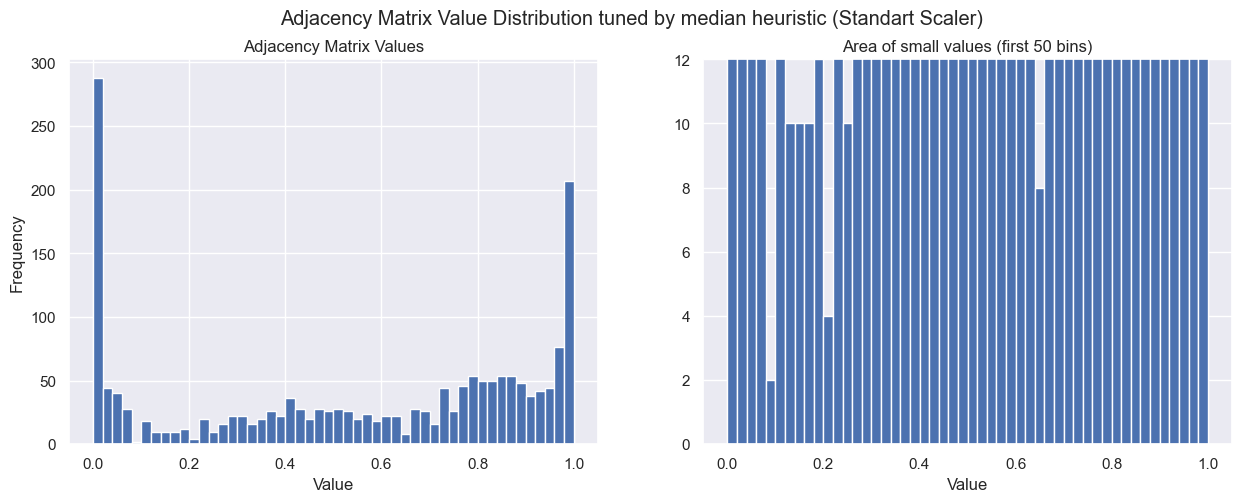

In [44]:
sns.set(font_scale=1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

bin_values, _, _ = ax1.hist(A_z.flatten(), bins=50)

ax2.hist(A_z.flatten(), bins=50)
ax2.set_ylim([0, bin_values[9]])
ax1.set_xlabel('Value')
ax2.set_xlabel('Value')
ax1.set_ylabel('Frequency')
ax1.set_title('Adjacency Matrix Values')
ax2.set_title('Area of small values (first 50 bins)')
fig.suptitle('Adjacency Matrix Value Distribution tuned by median heuristic (Standart Scaler)')
plt.show()

In [45]:
X_rob = RobustScaler().fit_transform(X)
distance_matrix_rob = pdist(X_rob, metric='euclidean')
sigma_rob = np.median(distance_matrix_z)
A_rob = -1 * np.square(X_rob[:, None] - X_rob[None, :]).sum(axis=-1)
A_rob = np.exp(A_rob / (2 * sigma_z**2))

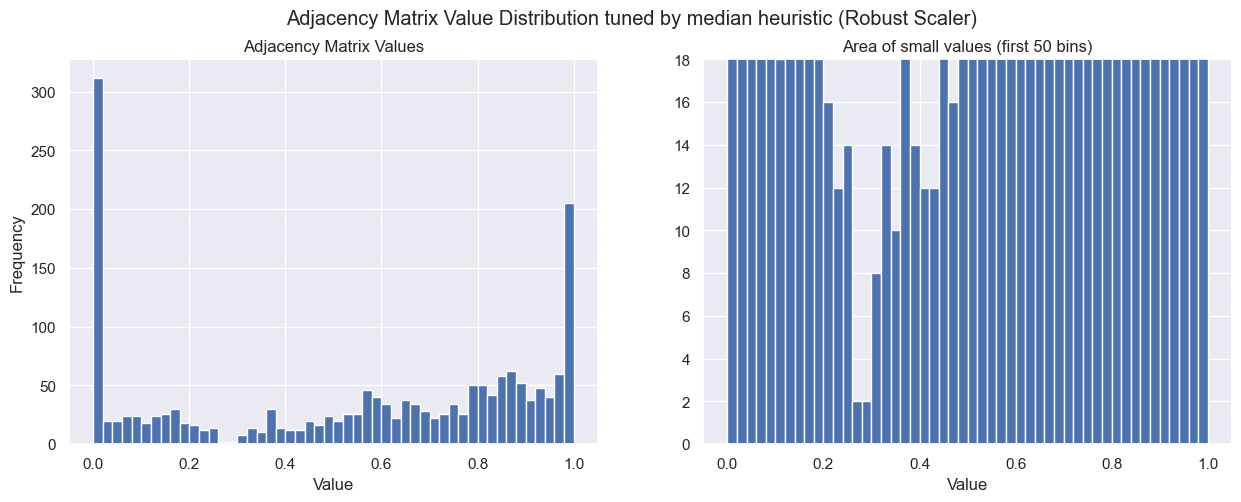

In [46]:
sns.set(font_scale=1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

bin_values, _, _ = ax1.hist(A_rob.flatten(), bins=50)

ax2.hist(A_rob.flatten(), bins=50)
ax2.set_ylim([0, bin_values[9]])
ax1.set_xlabel('Value')
ax2.set_xlabel('Value')
ax1.set_ylabel('Frequency')
ax1.set_title('Adjacency Matrix Values')
ax2.set_title('Area of small values (first 50 bins)')
fig.suptitle('Adjacency Matrix Value Distribution tuned by median heuristic (Robust Scaler)')
plt.show()

## 9. Addition: Plotly Dashboard

In [47]:
# 9.1. Origin Dataset plot
fig = px.scatter(df, x='Sorption, mmol/g', y='ε',
                 hover_name='Name', title='Scatter plot of the substances',
                 width=800, height=600)
fig.show()

In [48]:
# 9.2. Clustering visualisation with OLS regression withing the clusters
def plotly_graph(y, name):
    clusters = y.astype(int)
    labels = (clusters + 1).astype(str)
    df_plot = pd.DataFrame({
        'Sorption (mmol/g)': X[:, 0],
        'ε (Dielectric constant)': X[:, 1],
        'Cluster': labels
    })

    order = [str(i) for i in range(1, int(clusters.max()) + 2)]
    fig = px.scatter(df_plot, x='Sorption (mmol/g)', y='ε (Dielectric constant)',
                    color='Cluster',
                    category_orders={'Cluster': order},
                    hover_name=df['Name'],
                    labels={'color': 'Cluster'},
                    trendline='ols',
                    title=f'Clusters of substances ({name})')
    fig.update_layout(
                    width=800, height=600)
    fig.show()

In [49]:
plotly_graph(y_kmeans,'K-Means')

In [50]:
plotly_graph(y_hc, 'Hierarchical')

In [51]:
clusters = y_spectral.astype(int)
labels = (clusters + 1).astype(str)
df_plot = pd.DataFrame({
    'Sorption (mmol/g)': X[:, 0],
    'ε (Dielectric constant)': X[:, 1],
    'Cluster': labels
})

order = [str(i) for i in range(1, int(clusters.max()) + 2)]
fig = px.scatter(df_plot, x='Sorption (mmol/g)', y='ε (Dielectric constant)',
                 color='Cluster',
                 category_orders={'Cluster': order},
                 hover_name=df['Name'],
                 labels={'color': 'Cluster'},
                 trendline='ols',
                 title='Clusters of substances (Spectral Clustering)',
                 width=800, height=600)
fig.show()

In [52]:
plotly_graph(dbscan.labels_, 'DBSCAN')

## 10. Conclusions

- Four methods were used to solve the clustering problem, of which three showed satisfactory results. Spectral clustering proved unsatisfactory for our data. 
- Based on the table:


- | Method        | Silhouette | Calinski–Harabasz | Davies–Bouldin |
  |---------------|------------|--------------------|----------------|
  | K-Means       | 0.61       | 328.85             | 0.50           |
  | Hierarchical  | **0.70**   | 285.95             | **0.43**       |
  | Spectral      | 0.06       | 7.30               | 2.70           |
  | DBSCAN        | 0.60       | 185.67             | 0.76           |




- **Hierarchical clustering** performs the best overall.  
It has the highest Silhouette score and the lowest Davies–Bouldin index, which means its clusters are compact and well separated.K-Means is also strong but slightly worse.

- A pipeline based on RANSAC and Sequential RANSAC has been built to search for linear correlations within each cluster, which will allow us to make a scientific interpretation of the interactions of solvents with graphene oxide.

- As an additional search for linear correlations, plotly dashboard was used, which returned regression equations with a minimum amount of code.